```
Copyright 2021 Twitter, Inc.
SPDX-License-Identifier: Apache-2.0
```

## 1.Demographic Bias Analysis FairFace

Results are recorded in .txt files.

In [1]:
import math
import os
import random
import shlex
import subprocess
import sys
import time
from pathlib import Path
import glob

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.patches import Rectangle
from PIL import Image

## Add seed for reproducibility
random.seed(42)
np.random.seed(42)

In [2]:
# ! rm -rf attached

In [2]:
import platform

BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

HOME_DIR = Path("../").expanduser()

try:
    import google.colab
    ! pip install pandas scikit-learn scikit-image statsmodels requests dash
    ! [[ -d image-crop-analysis ]] || git clone https://github.com/twitter-research/image-crop-analysis.git
    HOME_DIR = Path("./image-crop-analysis").expanduser()
    IN_COLAB = True
except:
    IN_COLAB = False

sys.path.append(str(HOME_DIR / "src"))
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"
data_dir = HOME_DIR / Path("./data/")
data_dir.exists()

True

# Collecting and Cleaning Data

In [3]:
def get_filepaths(directory):
    file_paths = []  # List which will store all of the full filepaths.
    file_paths = [str(p) for p in Path(directory).glob("*")]
    return file_paths

## Read and process data

In [5]:
# [Instruction]: out the folder directory which contains all the images here
IMG_DIR_PATH = data_dir / "./fairface/fairface-img-margin125-trainval/"
print("Directory exists:", Path(IMG_DIR_PATH).exists())

# get the list of all files path
full_file_paths = get_filepaths(IMG_DIR_PATH / "./train")

Directory exists: True


In [6]:
from PIL import Image
import cv2
from tqdm import tqdm

def is_RGB(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b: 
                return True
    return False

cascPath = "haarcascade_frontalface_default.xml"

# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascPath)

def no_of_faces(img_path):
    # Read the image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    
    return len(faces)
    

In [7]:
# tqdm.pandas()

# DATA_PATH = data_dir / "./fairface/fairface_label_train.csv"
# print("File exists:", Path(DATA_PATH).exists())

# df = pd.read_csv(DATA_PATH)
# df["path"] = df.file.apply(lambda x: IMG_DIR_PATH / x)
# df = df[df["race"].isin(["White", "Black", "Indian", "East Asian"])]
# df = df[df["age"].isin(["20-29", "30-39", "40-49"])]

# df['RGB'] = df['path'].progress_apply(is_RGB)
# df = df[df['RGB'] == True]

# df['faces'] = df['path'].progress_apply(no_of_faces)
# df = df[df['faces'] <= 1]

# DATA_PATH = data_dir / "./fairface/fairface_label_train_cleaned.csv"
# df.to_csv(DATA_PATH, index=False)

# df

In [16]:
DATA_PATH = data_dir / "./fairface/fairface_label_train_cleaned.csv"
print("File exists:", Path(DATA_PATH).exists())

df = pd.read_csv(DATA_PATH)
df = df[df["race"].isin(["White", "Black"])]
df = df[df["age"].isin(["20-29", "30-39", "40-49"])]                

df

File exists: True


,file,age,gender,race,service_test,path,RGB,faces
2,train/6.jpg,20-29,Male,White,True,../data/fairface/fairface-img-margin125-trainv...,True,1
5,train/16.jpg,30-39,Female,White,False,../data/fairface/fairface-img-margin125-trainv...,True,1
7,train/23.jpg,20-29,Female,Black,True,../data/fairface/fairface-img-margin125-trainv...,True,0
8,train/24.jpg,30-39,Female,White,False,../data/fairface/fairface-img-margin125-trainv...,True,1
9,train/26.jpg,30-39,Female,Black,True,../data/fairface/fairface-img-margin125-trainv...,True,1
...,...,...,...,...,...,...,...,...
27817,train/86712.jpg,40-49,Female,White,False,../data/fairface/fairface-img-margin125-trainv...,True,1
27821,train/86727.jpg,40-49,Female,White,True,../data/fairface/fairface-img-margin125-trainv...,True,1
27823,train/86733.jpg,40-49,Female,White,False,../data/fairface/fairface-img-margin125-trainv...,True,1
27824,train/86737.jpg,20-29,Male,Black,False,../data/fairface/fairface-img-margin125-trainv...,True,1


In [9]:
RACE_SIZE_THRESHOLD = 40
race_size_pandas = df.groupby("race").size()
print(
    "top race group by size:\n", race_size_pandas.sort_values(ascending=False)[:20]
)
race_big_enough = race_size_pandas[
    race_size_pandas.values >= RACE_SIZE_THRESHOLD
].index.values

top race group by size:
 race
White    9269
Black    6046
dtype: int64


In [22]:
# cut if the group is too small
GROUP_THRESHOLD = 100

def get_grouped_images(
    df, by_columns=["race"], group_threshold=GROUP_THRESHOLD
):
    """
    race_threshold: if the size of the group is less than the threshold, then ignore the group to be in the dictionary
    """
    grouped_images_dict = {}
    grouped_images_race = df.groupby(by_columns)

    for name, group in grouped_images_race:
        print(name)
        print("Size of the group:", len(group))
        if group_threshold is not None:
            if len(group) < group_threshold:
                print("\tSize is smaller than", group_threshold, ". Skip this group.")
                continue
        grouped_images_dict[name] = group

    return grouped_images_dict

In [11]:
# choose your option here
grouped_images_dict = get_grouped_images(
    df, by_columns=["race", "gender"]
)

('Black', 'Female')
Size of the group: 3104
('Black', 'Male')
Size of the group: 2942
('White', 'Female')
Size of the group: 4500
('White', 'Male')
Size of the group: 4769


In [12]:
grouped_images_dict.keys()

dict_keys([('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male')])

# Setting up Tools to use

In [26]:
def img_resize_fixed_aspect(img, fixed_width=None, fixed_height=256):
    w, h = img.size
    if fixed_height:
        return img.resize((int(w * fixed_height / h), fixed_height))
    elif fixed_width:
        raise Exception("Not implemented.")


def attach_img(
    images,
    fixed_height=None,
    display_img_full_size=False,
    display_figsize=None,
    pixel_size_upperbound=None,
):
    """
    Given a list of images (of PIL Image class or image paths), attach them horizontally and return a new image.
    
    images: list of images or a list of paths to images
    fixed_height: all images are resized (while fixing the aspect ratio) to the specified height.
    If you don't want to resize, set this to None
    display_img_full_size: If true, will display the image at full resolution
    display_figsize: if given, as (x,y), will use matplotlib to display images with figsize=(x,y)
    pixel_size_upperbound: if given, images with width or height above this number will be resized down 
    while fixing the aspect ratio until both the width and height is at most the number.
    """
    if isinstance(images[0], str) or isinstance(images[0], Path):
        images = [Image.open(str(img_path)) for img_path in images]
    if fixed_height is not None:
        images = [
            img_resize_fixed_aspect(img, fixed_height=fixed_height) for img in images
        ]
    if pixel_size_upperbound is not None:
        for i in range(len(images)):
            w, h = images[i].size
            if w > pixel_size_upperbound:
                images[i] = images[i].resize(
                    (pixel_size_upperbound, int(pixel_size_upperbound / w * h))
                )
            w, h = images[i].size
            if h > pixel_size_upperbound:
                images[i] = images[i].resize(
                    (int(pixel_size_upperbound / h * w), pixel_size_upperbound)
                )
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new("RGB", (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    if display_img_full_size:
        display(new_im)  # This shows image at full resolution
    if display_figsize:
        fig = plt.figure(figsize=display_figsize)
        plt.imshow(
            np.asarray(new_im)
        )  # This shows scaled down version in matplotlib plot using figsize
    return (new_im, widths, heights)

### Run below cell if want to explore the images

Black  size:  6046


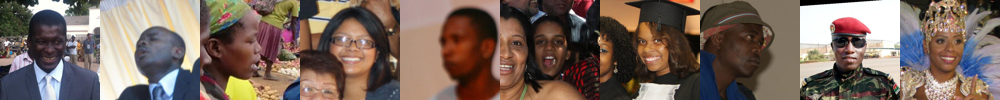

White  size:  9269


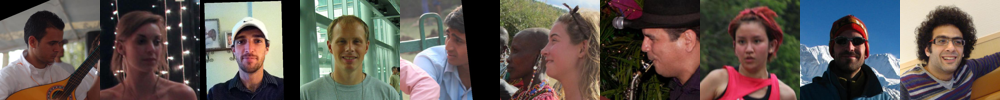

Male


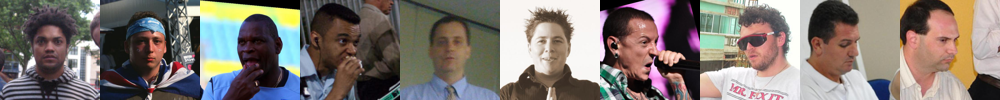

Female


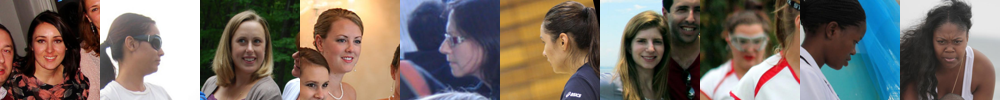

In [14]:
for race in race_big_enough:
    print(
        race, " size: ", race_size_pandas.loc[race]
    )
    display(
        attach_img(
            df[df.race == race]
            .sample(n=10, replace=True)
            .path.values,
            fixed_height=100,
        )[0]
    )

for gender in df.gender.unique():
    print(gender)
    display(
        attach_img(
            df[df.gender == gender]
            .sample(n=10, replace=True)
            .path.values,
            fixed_height=100,
        )[0]
    )

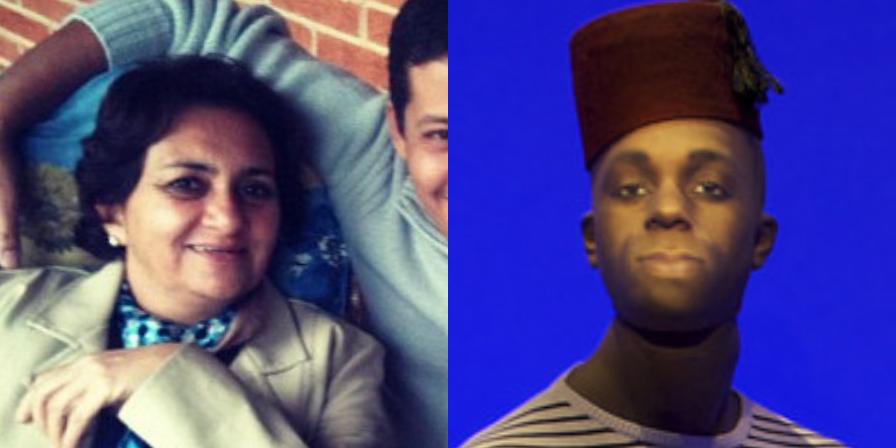

widths: (448, 448)
heights: (448, 448)


In [15]:
(new_im, widths, heights) = attach_img(full_file_paths[0:2], fixed_height=None)
display(new_im)
print("widths:", widths)
print("heights:", heights)


In [27]:
def locate_which_img(location, widths):
    """
    Given a list of widths of the images that are attached (from left to right), and a location,
    output what image contains that location.
    E.g. widths = 100, 200, 100
    location = 50 --> index = 0
    location = 350 --> index = 2
    location = 100 --> index = 1
    location >= 400 --> index = -1
    """
    index = 0
    while location >= widths[index]:
        location -= widths[index]
        index += 1
        if index >= len(widths):
            return -1
    return index

In [28]:
def parse_output(output):
    output = output.splitlines()
    final_output = {"salient_point": [], "crops": [], "all_salient_points": []}
    key = "salient_point"
    for i, line in enumerate(output):
        line = line.split()
        if len(line) in {2, 4}:
            line = [int(v) for v in line]
            if i != 0:
                key = "crops"
        elif len(line) == 3:
            key = "all_salient_points"
            line = [float(v) for v in line]
        else:
            raise RuntimeError(f"Invalid line: {line}")
        final_output[key].append(line)
    return final_output

In [29]:
def get_salient_info(img_path):
    """
    Given a path (as an instance of Path or a string or an image), output the salient information.
    
    The output is a dictionary with:
    'salient_point': a list of pixels, usually only one. E.g. [[507, 328]]
    'crops': a list of crops (for each aspect ratio) in the format crop_x crop_y crop_w crop_h
    'all_salient_points': the pixel location at the original image with its salient score. It is a list of
    [x, y, salient score]
    """
    if isinstance(img_path, str):
        img_path = Path(img_path)
    try:
        cmd = f"{str(bin_path)} {str(model_path)} '{img_path.absolute()}' show_all_points"
        output = subprocess.check_output(cmd, shell=True)  # Success!
        return parse_output(output)
    except:
        print("Running the model to get salient point fails. Returning None.")
        return None

In [19]:
salient_scores = [
    point[2] for point in get_salient_info(full_file_paths[3])["all_salient_points"]
]
np.percentile(salient_scores, 100)
np.mean(salient_scores)

0.5868125209449999

## Higher-level Tools

In [20]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

True

In [21]:
RESULT_FILE_PATH = data_dir / "./fairface_2race_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

True

### Pairwise comparison

In [9]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)

In [30]:
def compute_group_comparison(
    df_list,
    save_dir=SAVE_DIR_ATTACHED,
    num_iterations=200,
    log_every=100,
    warn_outside_ori_image=True,
    fixed_height=None,
    pixel_size_upperbound=None,
):
    """
    Given a list of dataframe of groups g_1, g_2, ..., g_k, each of which contains the column 'path' to the image file:
    - sample uniformly one image from each group
    - attach image into one image
    - apply saliency mapping
    - find the number of times max salient points land in each picture
    """
    num_max_salient_per_group = np.zeros(len(df_list))
    for i in range(num_iterations):
        salient_info = None
        while salient_info is None:  # if cmd in get_salient_info failed, resample
            # Sample images as paths
            sample_img_paths = [(df.sample())["path"].item() for df in df_list]
            attached_img, widths, heights = attach_img(
                sample_img_paths,
                fixed_height=fixed_height,
                pixel_size_upperbound=pixel_size_upperbound,
            )
            attached_path = str(save_dir) + "/" + str(i) + ".jpg"
            attached_img.save(attached_path)
            # try to get salient information. Will get None if fails.
            salient_info = get_salient_info(attached_path)

        # get salient point and where it lands
        all_salient_points = salient_info["salient_point"]
        if len(all_salient_points) > 1:
            print(
                "Warning: there is more than one maximum salient point. Using the first one returned from the algorithms."
            )
        salient_point_x, salient_point_y = all_salient_points[0]
        max_salient_pic_index = locate_which_img(salient_point_x, widths)
        if warn_outside_ori_image and salient_point_y >= heights[max_salient_pic_index]:
            # this means the point is outside of the original image
            print(
                "Warning: salient point is located at the background from attaching images, outside of original."
            )
        num_max_salient_per_group[max_salient_pic_index] += 1
        if (i + 1) % log_every == 0:
            print((i + 1), "/", num_iterations, "iterations of sampling has been done.")
    return num_max_salient_per_group

In [31]:
# In general, we can give the name of two groups in grouped_images_dict, and return this statistics of how many land in each
def compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    normalize=False,
    save_dir=SAVE_DIR_ATTACHED,
    num_iterations=200,
    fixed_height=None,
    pixel_size_upperbound=None,
    save_result=RESULT_FILE_PATH,
    log_every=100,
    print_summary=True,
    save_setting="default",
):
    """
    Given a list of group names, which are keys of the dictionary grouped_images_dict,
    whose values are pandas dataframe with column "path",
    return the number of times salient points lands in each of the group out of num_iterations iterations of sampling.
    
    Args:
        grouped_images_dict: a dictionary where keys are group names, and values are pandas dataframe which contains 'path'
    """
    start_time = time.time()
    stats = compute_group_comparison(
        [grouped_images_dict[group_name] for group_name in group_name_list],
        save_dir=save_dir,
        num_iterations=num_iterations,
        fixed_height=fixed_height,
        log_every=log_every,
        pixel_size_upperbound=pixel_size_upperbound,
    )
    if normalize:
        stats = stats / num_iterations
    if print_summary:
        print("The groups entered are: " + str(group_name_list))
        print("The statistic is: " + str(stats))
        print("Size of the sample: " + str(num_iterations))
    if save_result:
        with open(RESULT_FILE_PATH, "a") as fp:
            to_write_info_dict = {
                "group_name_list": group_name_list,
                "stats": stats,
                "num_iterations": num_iterations,
            }
            if save_setting:
                to_write_info_dict["setting"] = save_setting
            fp.write(str(to_write_info_dict) + "\n")
    time_used = time.time() - start_time
    print("total time used:", time_used, "seconds.")
    print("time used per comparison:", time_used / num_iterations, "seconds.")
    return stats

### Get a list of saliency point statistics

Such as max, 95th, 90th, 50th, and 25th percentile

In [32]:
def compute_saliency_stats(
    file_path_list,
    sample=None,
    percentile_queries=[25, 50, 75, 90, 95, 100],
    fixed_height=None,
    pixel_size_upperbound=None,
    save_dir=SAVE_DIR_ATTACHED,
    log_every=100,
    print_summary=True,
    delete_img=True,
):
    """
    Given a list of paths to images, compute saliency statistics of interests of all those images.
    
    Args:
        sample: None if we want to compute all. If a number is given, only do the specified number of samples (without replacement)

    Returns:
        pandas dataframe with file_path as an index, and the statistics as a column
    """
    start_time = time.time()

    if sample is not None:
        file_path_list = random.sample(file_path_list, sample)

    result_data = {
        str(percent) + "%_tile": [] for percent in percentile_queries
    }  # all columns
    result_data["path"] = []  # rows of the data
    result_data["mean"] = []

    for i, path in enumerate(file_path_list):
        attached_img, widths, heights = attach_img(
            [path],
            fixed_height=fixed_height,
            pixel_size_upperbound=pixel_size_upperbound,
        )
        attached_path = str(save_dir) + "/" + str(i) + ".jpg"
        attached_img.save(attached_path)
        # try to get salient information. Will get None if fails.
        salient_info = get_salient_info(attached_path)
        # After getting the info delete the file:
        if delete_img:
            Path(attached_path).unlink()

        salient_scores = [point[2] for point in salient_info["all_salient_points"]]

        # put data in
        result_data["path"].append(path)
        result_data["mean"].append(np.mean(salient_scores))
        for percent in percentile_queries:
            result_data[str(percent) + "%_tile"].append(
                np.percentile(salient_scores, percent)
            )

        if (i + 1) % log_every == 0:
            print((i + 1), "iterations of sampling has been done.")

    time_used = time.time() - start_time
    print("total time used:", time_used, "seconds.")
    print("time used per comparison:", time_used / len(file_path_list), "seconds.")

    return pd.DataFrame.from_dict(result_data).set_index("path")

# Analysis

Change the setting and setting name below (for saving purpose), and modify `all_pairs_replicate_ori` as needed.

In [26]:
# change the setting here
NUM_ITERATION = 500
FIXED_HEIGHT = (
    256
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "fairface_2race_fixed_height_intersect"  # for saving results and plots

In [27]:
all_race_to_compare = list(grouped_images_dict.keys())
all_pairs_replicate_ori = [
    (all_race_to_compare[i], all_race_to_compare[j])
    for i in range(len(all_race_to_compare))
    for j in range(i + 1, len(all_race_to_compare))
]

In [28]:
# another way, if we want to flip
all_pairs_replicate_ori

[(('Black', 'Female'), ('Black', 'Male')),
 (('Black', 'Female'), ('White', 'Female')),
 (('Black', 'Female'), ('White', 'Male')),
 (('Black', 'Male'), ('White', 'Female')),
 (('Black', 'Male'), ('White', 'Male')),
 (('White', 'Female'), ('White', 'Male'))]

In [29]:
max_salient_compare_dict = {}

for pair in all_pairs_replicate_ori:
    max_salient_compare_dict[pair] = compute_comparison_from_group_name(
        grouped_images_dict,
        pair,
        num_iterations=NUM_ITERATION,
        save_setting=SETTING_NAME,
        fixed_height=FIXED_HEIGHT,
        pixel_size_upperbound=DIM_BOUND,
    )

100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('Black', 'Male'))
The statistic is: [291. 209.]
Size of the sample: 500
total time used: 157.97464966773987 seconds.
time used per comparison: 0.3159492993354797 seconds.
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('White', 'Female'))
The statistic is: [237. 263.]
Size of the sample: 500
total time used: 181.57412838935852 seconds.
time used per comparison: 0.36314825677871704 seconds.
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling 

In [12]:
def plot_pairwise_stats(
    stat_dict,
    figsize=None,
    setting_name="unknown",
    num_iteration="unknown",
    confidence_interval_err=2,
    middle_band_width=0.1,
    x_label_angle=10,
):
    """
  Given a dictionary of pairs of group and comparison statisitcs:
  ('group1', 'group2'): [num_group1_is_picked, num_group2_is_picked]
  Plot the bar graph on all pairs in this format on the probability p that group1 is picked.
  
  The std error is assumed to be sqrt(p(1-p)/n), a confidence interval for Bernoulli inference.
  The bar graph plot +- 2 std err, giving 95% confidence interval.
  
  Args:
      confidence_interval_err: the width of the confidence interval in the plotsetting_name: the setting of this experiment. Only used for the title of the plot and name of the saved figure
      num_iteration: the number of samples used (int or str). Only used for the title of the plot and name of the saved figure
      x_label_angle: angle to rotate the x label. May need to increase for lengthy labels.
      middle_band_width: add two horizontal lines above and below 0.5 symmetrically to the plot, so creating a band of given width.
                    If None, no line is added.
  """
    x_labels = [
        "{}-{}".format(*pair[0]) + "\nhigher than\n" + "{}-{}".format(*pair[1])
        for pair in stat_dict.keys()
    ]
    prob = [val[0] / (val[0] + val[1]) for val in stat_dict.values()]
    total = [(val[0] + val[1]) for val in stat_dict.values()]
    y_err = [
        confidence_interval_err * math.sqrt(p * (1 - p) / n)
        for p, n in zip(prob, total)
    ]
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x_labels, prob, yerr=y_err)

    if middle_band_width is not None:
        ax.axhline(0.5, color="r", label=f"Demographic Parity")
    plt.xlim(-0.5, len(x_labels) - 0.5)
    plt.xticks(rotation=x_label_angle, fontsize=16)
    ax.set_ylabel("Probability $\pm$ 2 * error", fontsize=20)
    plt.ylim(0.0, 1.0)
    plt.yticks(fontsize=16)
    ax.yaxis.grid(True)
    plt.legend(fontsize=16)
    plt.title(f"Probabilities with {num_iteration} samples", fontsize=20)
    plt.tight_layout()
    plt.savefig(setting_name + "_n=" + str(num_iteration) + ".jpg")

In [31]:
max_salient_compare_dict

{(('Black', 'Female'), ('Black', 'Male')): array([291., 209.]),
 (('Black', 'Female'), ('White', 'Female')): array([237., 263.]),
 (('Black', 'Female'), ('White', 'Male')): array([283., 217.]),
 (('Black', 'Male'), ('White', 'Female')): array([218., 282.]),
 (('Black', 'Male'), ('White', 'Male')): array([228., 272.]),
 (('White', 'Female'), ('White', 'Male')): array([262., 238.])}

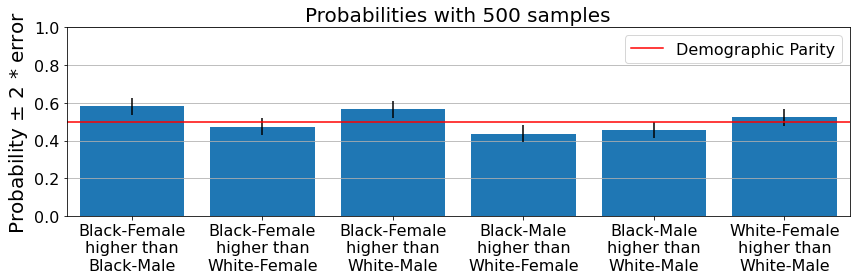

In [32]:
plot_pairwise_stats(
    max_salient_compare_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(12, 4),
    x_label_angle=0,
)

## Pairing across all groups at once

In [33]:
# change the setting here
NUM_ITERATION = 2000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept

In [34]:
group_name_list = [('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male')]

SETTING_NAME = "fairface_2race_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 2000 iterations of sampling has been done.
200 / 2000 iterations of sampling has been done.
300 / 2000 iterations of sampling has been done.
400 / 2000 iterations of sampling has been done.
500 / 2000 iterations of sampling has been done.
600 / 2000 iterations of sampling has been done.
700 / 2000 iterations of sampling has been done.
800 / 2000 iterations of sampling has been done.
900 / 2000 iterations of sampling has been done.
1000 / 2000 iterations of sampling has been done.
1100 / 2000 iterations of sampling has been done.
1200 / 2000 iterations of sampling has been done.
1300 / 2000 iterations of sampling has been done.
1400 / 2000 iterations of sampling has been done.
1500 / 2000 iterations of sampling has been done.
1600 / 2000 iterations of sampling has been done.
1700 / 2000 iterations of sampling has been done.
1800 / 2000 iterations of sampling has been done.
1900 / 2000 iterations of sampling has been done.
2000 / 2000 iterations of sampling has been done.
The group

In [35]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(group_name_list, max_salient_all_groups_stats)
}

In [13]:
def plot_dict_values(
    stat_dict,
    figsize=None,
    setting_name="unknown",
    num_iteration="unknown",
    confidence_interval_err=2,
    middle_band_width=0.1,
    x_label_angle=10,
):
    x_labels = ["{}-{}".format(*group_name) for group_name in stat_dict.keys()]
    print(x_labels)
    total = sum(stat_dict.values())
    print(type(total), type(list(stat_dict.values())))
    prob = list(stat_dict.values()) / total
    y_err = [confidence_interval_err * math.sqrt(p * (1 - p) / total) for p in prob]

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x_labels, prob, yerr=y_err)

    ax.plot(
        [-0.5, len(x_labels) - 0.5],
        np.full(2, 1 / len(x_labels)),
        "r",
        label=f"average",
    )

    plt.xticks(rotation=x_label_angle, fontsize=16)
    ax.set_ylabel("Probability $\pm$ 2 * error", fontsize=20)
    plt.ylim(0.0, 1.0)
    ax.yaxis.grid(True)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.title(f"Probabilities with {num_iteration} samples", fontsize=20)
    plt.tight_layout()
    plt.savefig(setting_name + "_n=" + str(num_iteration) + ".jpg")

In [37]:
max_salient_all_groups_stats

array([496., 266., 665., 573.])

In [38]:
max_salient_all_groups_dict

{('Black', 'Female'): 496.0,
 ('Black', 'Male'): 266.0,
 ('White', 'Female'): 665.0,
 ('White', 'Male'): 573.0}

['Black-Female', 'Black-Male', 'White-Female', 'White-Male']
<class 'numpy.float64'> <class 'list'>


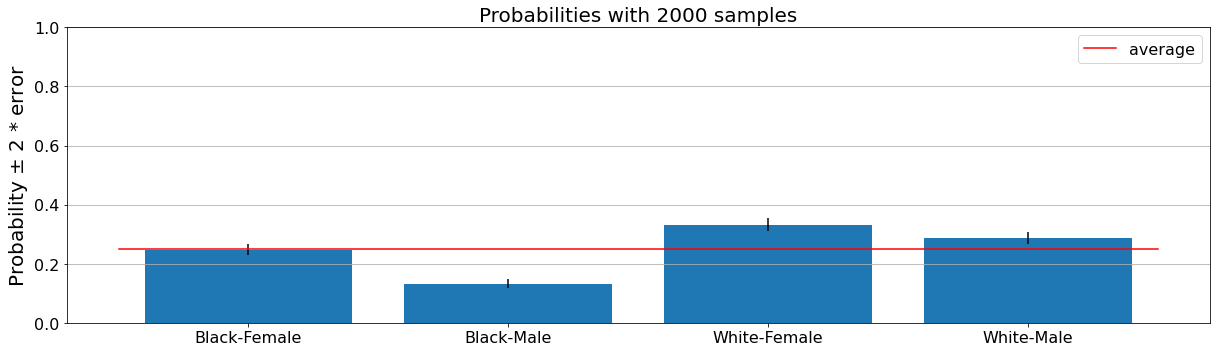

In [39]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

## Stats of saliency scores

In [52]:
# change the setting here
NUM_ITERATION = 500  # None # None if want to do whole thing
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "faiface_2race_no_scaling_intersect_stat"  # for saving results and plots

In [53]:
all_stats_dict = {}
for key in grouped_images_dict.keys():
    print("Computing stats for:", key)
    file_path_list = grouped_images_dict[key].path.values.tolist()
    all_stats_dict[key] = compute_saliency_stats(
        file_path_list,
        sample=NUM_ITERATION,
        percentile_queries=[50, 95, 100],
        fixed_height=None,
        pixel_size_upperbound=None,
        save_dir=SAVE_DIR_ATTACHED,
        log_every=100,
        print_summary=True,
    )

Computing stats for: ('Black', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 277.5129418373108 seconds.
time used per comparison: 0.5550258836746216 seconds.
Computing stats for: ('Black', 'Male')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 261.0907235145569 seconds.
time used per comparison: 0.5221814470291137 seconds.
Computing stats for: ('White', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 289.24923729896545 seconds.
time use

In [14]:
def prob_a_less_than_b(a, b):
    """
    Given two lists a,b, calculate the probability that
    random samples x,y from a,b will satisfies a < b
    
    Clculating this exactly for lists of length n, m takes runtime O(n log n + m log m) (for sorting),
    then O(n + m) in addition (without sorting)
    """
    a = sorted(a)
    b = sorted(b)

    prob = 0
    j = 0  # index of b that keeps moving till x > y
    for i, x in enumerate(a):
        while (j < len(b)) and (x >= b[j]):
            j += 1
        prob += (len(b) - j) / (len(a) * len(b))

    return prob

In [55]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["100%_tile"].values,
                all_stats_dict[group_list[j]]["100%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5441840000000002
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.540464
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.5826840000000002
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.4999000000000001
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.5421360000000002
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.5401120000000001


In [56]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["95%_tile"].values,
                all_stats_dict[group_list[j]]["95%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5539239999999996
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5695080000000001
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.6154880000000003
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.514508
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.5616880000000002
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.5472960000000007


In [57]:
for (g1, g2), df_t in all_stats_dict.items():
    out_path = f"./fairface_2race_all_stats_dict_{g1}_{g2}.tsv"
    print(out_path)
    df_t.to_csv(out_path, sep="\t")

./fairface_2race_all_stats_dict_Black_Female.tsv
./fairface_2race_all_stats_dict_Black_Male.tsv
./fairface_2race_all_stats_dict_White_Female.tsv
./fairface_2race_all_stats_dict_White_Male.tsv


In [58]:
print(f"Setting = {SETTING_NAME}")

Setting = faiface_2race_no_scaling_intersect_stat


In [15]:
def plot_group_saliency_histogram(
    group_to_plot, col_names=None, col_name_title_map=None, file_id=None, **hist_kwargs
):
    if col_names is None:
        col_names = ["50%_tile", "95%_tile", "100%_tile", "mean"]
    if col_name_title_map is None:
        col_name_title_map = {"50%_tile": "median", "100%_tile": "max"}
    for col_name in col_names:  # columns from any pandas dataframe
        plt_title = col_name_title_map.get(col_name, col_name)
        fig = plt.figure(figsize=(5, 2))
        for key in group_to_plot:
            g1, g2 = key
            out_path = f"./fairface_all_stats_dict_{g1}_{g2}.tsv"
            pandas_data = pd.read_csv(out_path, sep="\t", index_col=0)
            plt.hist(pandas_data[col_name], label=f"{g1}-{g2}", **hist_kwargs)
        plt.ylabel("frequency")
        plt.title(f"Distribution of {plt_title} saliency")
        plt.legend(loc="upper left")
        plt.tight_layout()
        plt.savefig(f"fairface_2race_saliency_dist_gender_dif_on_{file_id}_{plt_title}.png")
        plt.show()

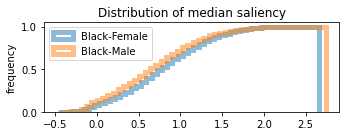

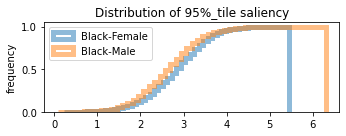

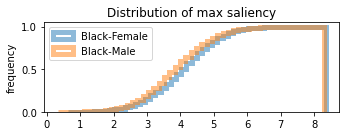

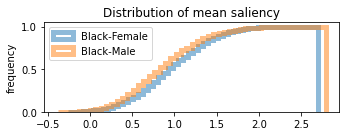

In [60]:
group_to_plot = [("Black", "Female"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="black",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

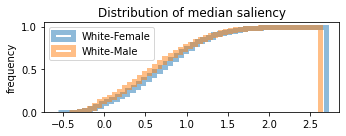

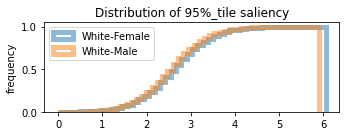

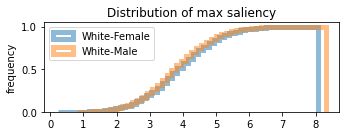

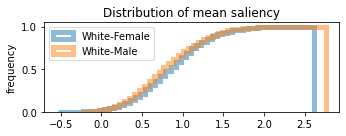

In [61]:
group_to_plot = [("White", "Female"), ("White", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

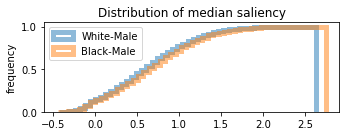

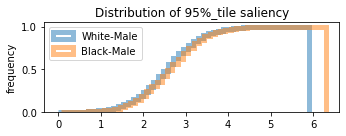

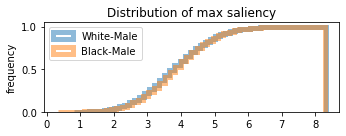

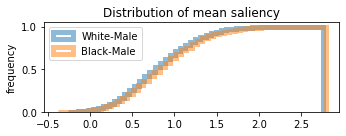

In [62]:
group_to_plot = [("White", "Male"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

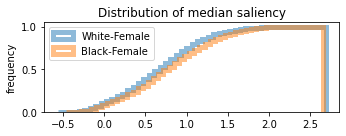

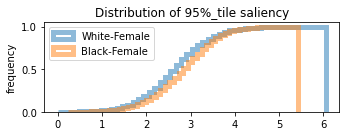

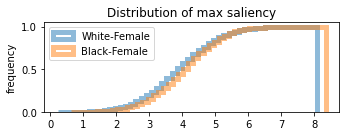

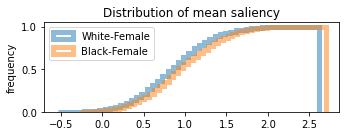

In [63]:
group_to_plot = [("White", "Female"), ("Black", "Female")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

## 2. Demographic Bias Analysis FairFace with Gun Artifacts

In [64]:
black_df = df[df["race"] == "Black"]
white_df = df[df["race"] == "White"]
black_male_df = black_df[black_df["gender"] == "Male"]
black_female_df = black_df[black_df["gender"] == "Female"]
white_male_df = white_df[white_df["gender"] == "Male"]
white_female_df = white_df[white_df["gender"] == "Female"]

In [65]:
from PIL import Image, ImageDraw, ImageFilter
import random

def create_manipulated_image(img_path, artifact_path, out_path):
    img_name = img_path.split("/")[-1]
    
    im1 = Image.open(img_path)
    im2 = Image.open(artifact_path).convert("RGBA")
    
    im1size = im1.size

    art_s1 = int(im1size[0] * random.uniform(0.0, 0.65))
    art_s2 = int(im1size[1] * random.uniform(0.0, 0.75))
    
    basewidth = int(random.uniform(200, 300))

    wpercent = (basewidth/float(im2.size[0]))
    hsize = int((float(im2.size[1])*float(wpercent)))
    im3 = im2.resize((basewidth,hsize), Image.ANTIALIAS)
    
    back_im = im1.copy()
    back_im.paste(im3, (art_s1,art_s2), mask = im3)
    back_im.save(f'{out_path}/{img_name}', quality=100)
    
    return None

In [66]:
# #Create Images with gun artifacts

# guns_artifacts = glob.glob("../data/artifacts/guns/*.png")

# !mkdir "../data/fairface/manipulated"


# d_path = "../data/fairface/manipulated/black-male-guns"
# !mkdir "../data/fairface/manipulated/black-male-guns"
# ims = list(black_male_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = guns_artifacts[int(random.uniform(0, len(guns_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/white-male-guns"
# !mkdir "../data/fairface/manipulated/white-male-guns"
# ims = list(white_male_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = guns_artifacts[int(random.uniform(0, len(guns_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/white-female-guns"
# !mkdir "../data/fairface/manipulated/white-female-guns"
# ims = list(white_female_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = guns_artifacts[int(random.uniform(0, len(guns_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/black-female-guns"
# !mkdir "../data/fairface/manipulated/black-female-guns"
# ims = list(black_female_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = guns_artifacts[int(random.uniform(0, len(guns_artifacts)))]
#     create_manipulated_image(img, artif, d_path)

In [67]:
def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-guns/{img_name}"
    
    return new_path

black_male_df["path"] = black_male_df["path"].apply(change_path)


def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-guns/{img_name}"
    
    return new_path

white_male_df["path"] = white_male_df["path"].apply(change_path)

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-guns/{img_name}"
    
    return new_path

black_female_df["path"] = black_female_df["path"].apply(change_path)

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-guns/{img_name}"
    
    return new_path

white_female_df["path"] = white_female_df["path"].apply(change_path)


/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [68]:
df2 = pd.concat([black_male_df, white_male_df, black_female_df, white_female_df], sort=True)
df2 = df2.sort_index()
df2

,RGB,age,faces,file,gender,path,race,service_test
2,True,20-29,1,train/6.jpg,Male,../data/fairface/manipulated/white-male-guns/6...,White,True
5,True,30-39,1,train/16.jpg,Female,../data/fairface/manipulated/white-female-guns...,White,False
7,True,20-29,0,train/23.jpg,Female,../data/fairface/manipulated/black-female-guns...,Black,True
8,True,30-39,1,train/24.jpg,Female,../data/fairface/manipulated/white-female-guns...,White,False
9,True,30-39,1,train/26.jpg,Female,../data/fairface/manipulated/black-female-guns...,Black,True
...,...,...,...,...,...,...,...,...
27817,True,40-49,1,train/86712.jpg,Female,../data/fairface/manipulated/white-female-guns...,White,False
27821,True,40-49,1,train/86727.jpg,Female,../data/fairface/manipulated/white-female-guns...,White,True
27823,True,40-49,1,train/86733.jpg,Female,../data/fairface/manipulated/white-female-guns...,White,False
27824,True,20-29,1,train/86737.jpg,Male,../data/fairface/manipulated/black-male-guns/8...,Black,False


In [69]:
grouped_images_dict = get_grouped_images(
    df2, by_columns=["race", "gender"]
)

('Black', 'Female')
Size of the group: 3104
('Black', 'Male')
Size of the group: 2942
('White', 'Female')
Size of the group: 4500
('White', 'Male')
Size of the group: 4769


In [70]:
grouped_images_dict.keys()

dict_keys([('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male')])

In [71]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

True

In [72]:
RESULT_FILE_PATH = data_dir / "./fairface_2race_gun_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

True

In [73]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)

In [74]:
#Analysis

# change the setting here
NUM_ITERATION = 500
FIXED_HEIGHT = (
    256
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "fairface_2race_gun_fixed_height_intersect"  # for saving results and plots

In [75]:
all_race_to_compare = list(grouped_images_dict.keys())
all_pairs_replicate_ori = [
    (all_race_to_compare[i], all_race_to_compare[j])
    for i in range(len(all_race_to_compare))
    for j in range(i + 1, len(all_race_to_compare))
]

In [76]:
# another way, if we want to flip
all_pairs_replicate_ori

[(('Black', 'Female'), ('Black', 'Male')),
 (('Black', 'Female'), ('White', 'Female')),
 (('Black', 'Female'), ('White', 'Male')),
 (('Black', 'Male'), ('White', 'Female')),
 (('Black', 'Male'), ('White', 'Male')),
 (('White', 'Female'), ('White', 'Male'))]

In [77]:
max_salient_compare_dict = {}

for pair in all_pairs_replicate_ori:
    max_salient_compare_dict[pair] = compute_comparison_from_group_name(
        grouped_images_dict,
        pair,
        num_iterations=NUM_ITERATION,
        save_setting=SETTING_NAME,
        fixed_height=FIXED_HEIGHT,
        pixel_size_upperbound=DIM_BOUND,
    )

100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('Black', 'Male'))
The statistic is: [288. 212.]
Size of the sample: 500
total time used: 215.99283051490784 seconds.
time used per comparison: 0.43198566102981567 seconds.
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('White', 'Female'))
The statistic is: [251. 249.]
Size of the sample: 500
total time used: 197.5116684436798 seconds.
time used per comparison: 0.39502333688735963 seconds.
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling 

In [78]:
max_salient_compare_dict

{(('Black', 'Female'), ('Black', 'Male')): array([288., 212.]),
 (('Black', 'Female'), ('White', 'Female')): array([251., 249.]),
 (('Black', 'Female'), ('White', 'Male')): array([257., 243.]),
 (('Black', 'Male'), ('White', 'Female')): array([222., 278.]),
 (('Black', 'Male'), ('White', 'Male')): array([219., 281.]),
 (('White', 'Female'), ('White', 'Male')): array([269., 231.])}

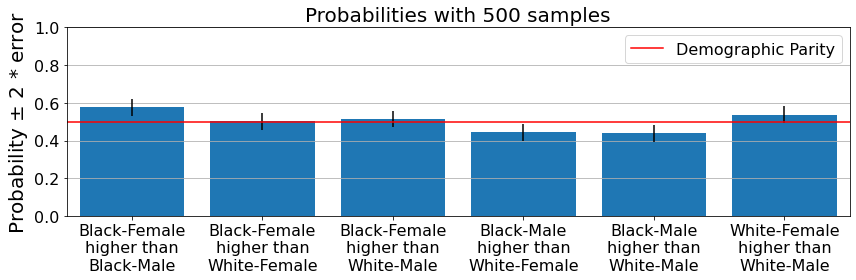

In [79]:
plot_pairwise_stats(
    max_salient_compare_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(12, 4),
    x_label_angle=0,
)

In [82]:
# change the setting here
NUM_ITERATION = 2000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept

In [83]:
group_name_list = [('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male')]

SETTING_NAME = "fairface_2race_gun_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 2000 iterations of sampling has been done.
200 / 2000 iterations of sampling has been done.
300 / 2000 iterations of sampling has been done.
400 / 2000 iterations of sampling has been done.
500 / 2000 iterations of sampling has been done.
600 / 2000 iterations of sampling has been done.
700 / 2000 iterations of sampling has been done.
800 / 2000 iterations of sampling has been done.
900 / 2000 iterations of sampling has been done.
1000 / 2000 iterations of sampling has been done.
1100 / 2000 iterations of sampling has been done.
1200 / 2000 iterations of sampling has been done.
1300 / 2000 iterations of sampling has been done.
1400 / 2000 iterations of sampling has been done.
1500 / 2000 iterations of sampling has been done.
1600 / 2000 iterations of sampling has been done.
1700 / 2000 iterations of sampling has been done.
1800 / 2000 iterations of sampling has been done.
1900 / 2000 iterations of sampling has been done.
2000 / 2000 iterations of sampling has been done.
The group

In [84]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(group_name_list, max_salient_all_groups_stats)
}

['Black-Female', 'Black-Male', 'White-Female', 'White-Male']
<class 'numpy.float64'> <class 'list'>


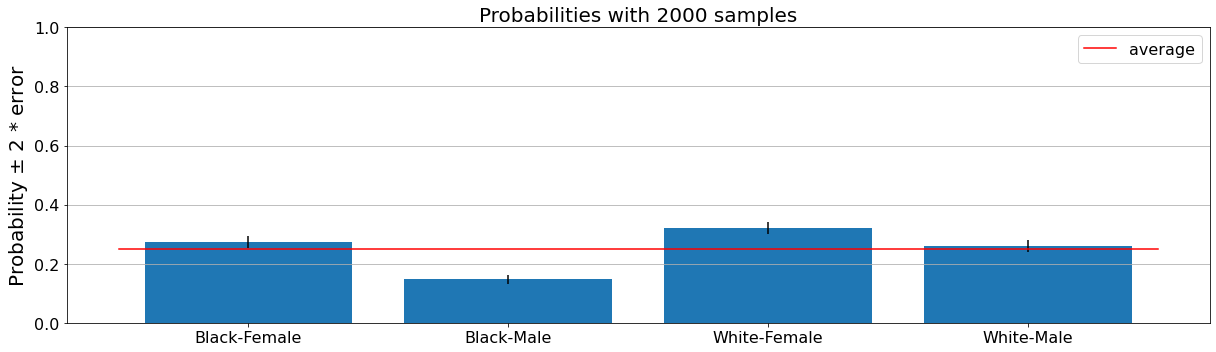

In [85]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [86]:
# change the setting here
NUM_ITERATION = 500  # None # None if want to do whole thing
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "faiface_2race_gun_no_scaling_intersect_stat"  # for saving results and plots

In [87]:
all_stats_dict = {}
for key in grouped_images_dict.keys():
    print("Computing stats for:", key)
    file_path_list = grouped_images_dict[key].path.values.tolist()
    all_stats_dict[key] = compute_saliency_stats(
        file_path_list,
        sample=NUM_ITERATION,
        percentile_queries=[50, 95, 100],
        fixed_height=None,
        pixel_size_upperbound=None,
        save_dir=SAVE_DIR_ATTACHED,
        log_every=100,
        print_summary=True,
    )

Computing stats for: ('Black', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 285.7904167175293 seconds.
time used per comparison: 0.5715808334350586 seconds.
Computing stats for: ('Black', 'Male')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 243.50108695030212 seconds.
time used per comparison: 0.48700217390060424 seconds.
Computing stats for: ('White', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 252.66095304489136 seconds.
time u

In [88]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["100%_tile"].values,
                all_stats_dict[group_list[j]]["100%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5532360000000001
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5737840000000002
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.5554639999999998
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.5191479999999997
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.5009159999999999
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.48166399999999965


In [89]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["95%_tile"].values,
                all_stats_dict[group_list[j]]["95%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5497759999999992
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5852239999999997
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.5859479999999995
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.5367679999999995
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.5375160000000004
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.5003799999999998


In [90]:
for (g1, g2), df_t in all_stats_dict.items():
    out_path = f"./fairface_2race_gun_all_stats_dict_{g1}_{g2}.tsv"
    print(out_path)
    df_t.to_csv(out_path, sep="\t")

./fairface_2race_gun_all_stats_dict_Black_Female.tsv
./fairface_2race_gun_all_stats_dict_Black_Male.tsv
./fairface_2race_gun_all_stats_dict_White_Female.tsv
./fairface_2race_gun_all_stats_dict_White_Male.tsv


In [91]:
print(f"Setting = {SETTING_NAME}")

Setting = faiface_2race_gun_no_scaling_intersect_stat


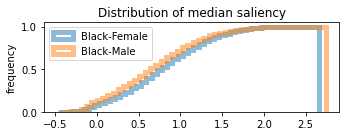

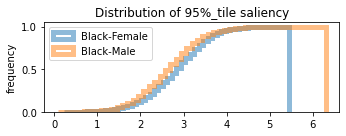

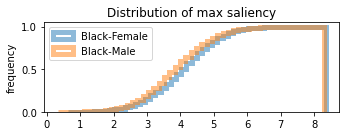

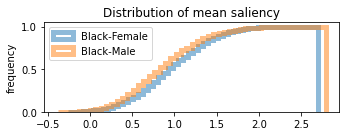

In [92]:
group_to_plot = [("Black", "Female"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="black",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

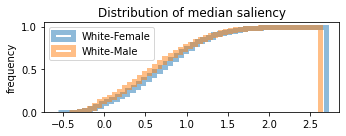

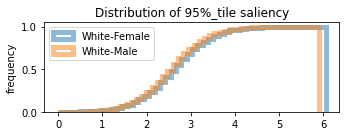

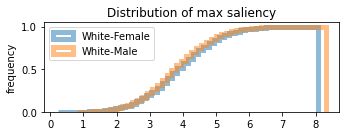

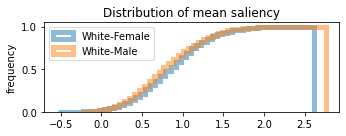

In [93]:
group_to_plot = [("White", "Female"), ("White", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

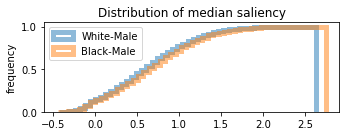

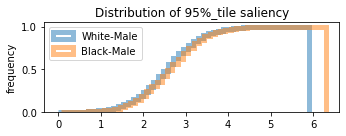

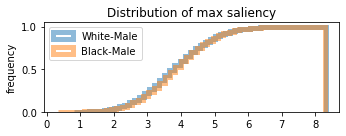

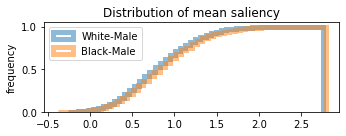

In [94]:
group_to_plot = [("White", "Male"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

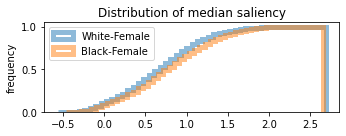

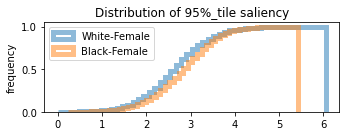

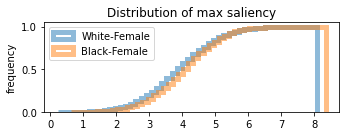

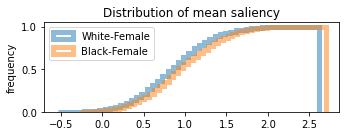

In [95]:
group_to_plot = [("White", "Female"), ("Black", "Female")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

## 3. Demographic Bias Analysis FairFace with Handcuff Artifacts

In [96]:
black_df = df[df["race"] == "Black"]
white_df = df[df["race"] == "White"]
black_male_df = black_df[black_df["gender"] == "Male"]
black_female_df = black_df[black_df["gender"] == "Female"]
white_male_df = white_df[white_df["gender"] == "Male"]
white_female_df = white_df[white_df["gender"] == "Female"]

In [97]:
# #Create Images with handcuff artifacts

# handcuffs_artifacts = glob.glob("../data/artifacts/handcuffs/*.png")

# !mkdir "../data/fairface/manipulated"


# d_path = "../data/fairface/manipulated/black-male-handcuffs"
# !mkdir "../data/fairface/manipulated/black-male-handcuffs"
# ims = list(black_male_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = handcuffs_artifacts[int(random.uniform(0, len(handcuffs_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/white-male-handcuffs"
# !mkdir "../data/fairface/manipulated/white-male-handcuffs"
# ims = list(white_male_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = handcuffs_artifacts[int(random.uniform(0, len(handcuffs_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/white-female-handcuffs"
# !mkdir "../data/fairface/manipulated/white-female-handcuffs"
# ims = list(white_female_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = handcuffs_artifacts[int(random.uniform(0, len(handcuffs_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/black-female-handcuffs"
# !mkdir "../data/fairface/manipulated/black-female-handcuffs"
# ims = list(black_female_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = handcuffs_artifacts[int(random.uniform(0, len(handcuffs_artifacts)))]
#     create_manipulated_image(img, artif, d_path)

In [98]:
def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-handcuffs/{img_name}"
    
    return new_path

black_male_df["path"] = black_male_df["path"].apply(change_path)


def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-handcuffs/{img_name}"
    
    return new_path

white_male_df["path"] = white_male_df["path"].apply(change_path)

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-handcuffs/{img_name}"
    
    return new_path

black_female_df["path"] = black_female_df["path"].apply(change_path)

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-handcuffs/{img_name}"
    
    return new_path

white_female_df["path"] = white_female_df["path"].apply(change_path)



/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [99]:
df2 = pd.concat([black_male_df, white_male_df, black_female_df, white_female_df], sort=True)
df2 = df2.sort_index()

In [100]:
grouped_images_dict = get_grouped_images(
    df2, by_columns=["race", "gender"]
)

('Black', 'Female')
Size of the group: 3104
('Black', 'Male')
Size of the group: 2942
('White', 'Female')
Size of the group: 4500
('White', 'Male')
Size of the group: 4769


In [101]:
grouped_images_dict.keys()

dict_keys([('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male')])

In [102]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

True

In [103]:
RESULT_FILE_PATH = data_dir / "./fairface_2race_handcuff_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

True

In [104]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)

In [105]:
#Analysis

# change the setting here
NUM_ITERATION = 500
FIXED_HEIGHT = (
    256
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "fairface_2race_handcuff_fixed_height_intersect"  # for saving results and plots

In [106]:
all_race_to_compare = list(grouped_images_dict.keys())
all_pairs_replicate_ori = [
    (all_race_to_compare[i], all_race_to_compare[j])
    for i in range(len(all_race_to_compare))
    for j in range(i + 1, len(all_race_to_compare))
]

In [107]:
# another way, if we want to flip
all_pairs_replicate_ori

[(('Black', 'Female'), ('Black', 'Male')),
 (('Black', 'Female'), ('White', 'Female')),
 (('Black', 'Female'), ('White', 'Male')),
 (('Black', 'Male'), ('White', 'Female')),
 (('Black', 'Male'), ('White', 'Male')),
 (('White', 'Female'), ('White', 'Male'))]

In [108]:
max_salient_compare_dict = {}

for pair in all_pairs_replicate_ori:
    max_salient_compare_dict[pair] = compute_comparison_from_group_name(
        grouped_images_dict,
        pair,
        num_iterations=NUM_ITERATION,
        save_setting=SETTING_NAME,
        fixed_height=FIXED_HEIGHT,
        pixel_size_upperbound=DIM_BOUND,
    )

100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('Black', 'Male'))
The statistic is: [282. 218.]
Size of the sample: 500
total time used: 206.07011437416077 seconds.
time used per comparison: 0.4121402287483215 seconds.
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('White', 'Female'))
The statistic is: [252. 248.]
Size of the sample: 500
total time used: 198.7667737007141 seconds.
time used per comparison: 0.3975335474014282 seconds.
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling ha

In [109]:
max_salient_compare_dict

{(('Black', 'Female'), ('Black', 'Male')): array([282., 218.]),
 (('Black', 'Female'), ('White', 'Female')): array([252., 248.]),
 (('Black', 'Female'), ('White', 'Male')): array([253., 247.]),
 (('Black', 'Male'), ('White', 'Female')): array([217., 283.]),
 (('Black', 'Male'), ('White', 'Male')): array([241., 259.]),
 (('White', 'Female'), ('White', 'Male')): array([256., 244.])}

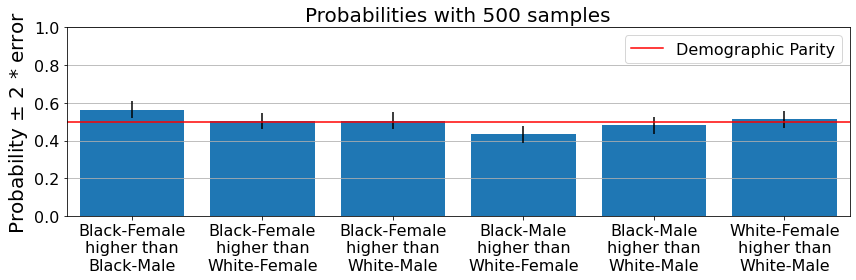

In [110]:
plot_pairwise_stats(
    max_salient_compare_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(12, 4),
    x_label_angle=0,
)

In [111]:
# change the setting here
NUM_ITERATION = 2000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept

In [112]:
group_name_list = [('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male')]

SETTING_NAME = "fairface_2race_handcuff_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 2000 iterations of sampling has been done.
200 / 2000 iterations of sampling has been done.
300 / 2000 iterations of sampling has been done.
400 / 2000 iterations of sampling has been done.
500 / 2000 iterations of sampling has been done.
600 / 2000 iterations of sampling has been done.
700 / 2000 iterations of sampling has been done.
800 / 2000 iterations of sampling has been done.
900 / 2000 iterations of sampling has been done.
1000 / 2000 iterations of sampling has been done.
1100 / 2000 iterations of sampling has been done.
1200 / 2000 iterations of sampling has been done.
1300 / 2000 iterations of sampling has been done.
1400 / 2000 iterations of sampling has been done.
1500 / 2000 iterations of sampling has been done.
1600 / 2000 iterations of sampling has been done.
1700 / 2000 iterations of sampling has been done.
1800 / 2000 iterations of sampling has been done.
1900 / 2000 iterations of sampling has been done.
2000 / 2000 iterations of sampling has been done.
The group

In [113]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(group_name_list, max_salient_all_groups_stats)
}

['Black-Female', 'Black-Male', 'White-Female', 'White-Male']
<class 'numpy.float64'> <class 'list'>


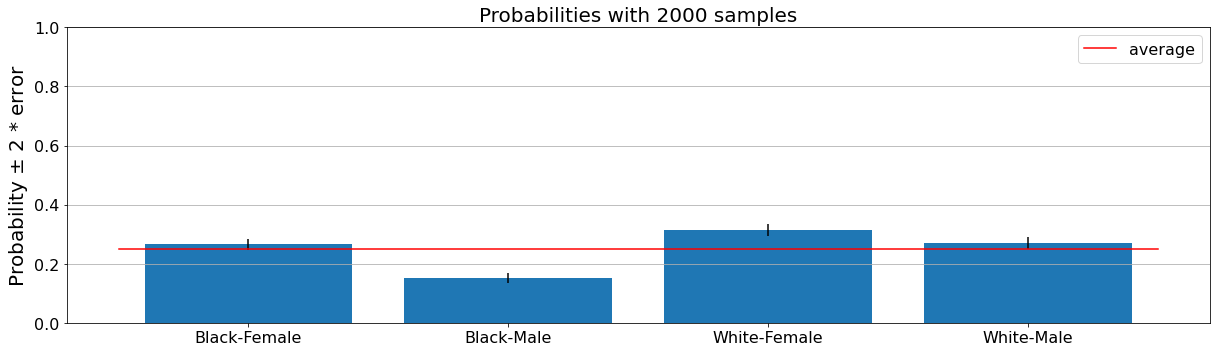

In [114]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [115]:
# change the setting here
NUM_ITERATION = 500  # None # None if want to do whole thing
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "faiface_2race_handcuff_no_scaling_intersect_stat"  # for saving results and plots

In [116]:
all_stats_dict = {}
for key in grouped_images_dict.keys():
    print("Computing stats for:", key)
    file_path_list = grouped_images_dict[key].path.values.tolist()
    all_stats_dict[key] = compute_saliency_stats(
        file_path_list,
        sample=NUM_ITERATION,
        percentile_queries=[50, 95, 100],
        fixed_height=None,
        pixel_size_upperbound=None,
        save_dir=SAVE_DIR_ATTACHED,
        log_every=100,
        print_summary=True,
    )

Computing stats for: ('Black', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 251.62785148620605 seconds.
time used per comparison: 0.5032557029724121 seconds.
Computing stats for: ('Black', 'Male')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 247.54853200912476 seconds.
time used per comparison: 0.4950970640182495 seconds.
Computing stats for: ('White', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 247.75324201583862 seconds.
time u

In [117]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["100%_tile"].values,
                all_stats_dict[group_list[j]]["100%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5172359999999994
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5382680000000001
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.5515679999999998
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.5217919999999998
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.5370960000000002
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.515884


In [118]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["95%_tile"].values,
                all_stats_dict[group_list[j]]["95%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5217519999999993
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5472520000000007
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.5852159999999995
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.5265560000000011
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.566411999999999
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.5388719999999998


In [119]:
for (g1, g2), df_t in all_stats_dict.items():
    out_path = f"./fairface_2race_handcuff_all_stats_dict_{g1}_{g2}.tsv"
    print(out_path)
    df_t.to_csv(out_path, sep="\t")

./fairface_2race_handcuff_all_stats_dict_Black_Female.tsv
./fairface_2race_handcuff_all_stats_dict_Black_Male.tsv
./fairface_2race_handcuff_all_stats_dict_White_Female.tsv
./fairface_2race_handcuff_all_stats_dict_White_Male.tsv


In [120]:
print(f"Setting = {SETTING_NAME}")

Setting = faiface_2race_handcuff_no_scaling_intersect_stat


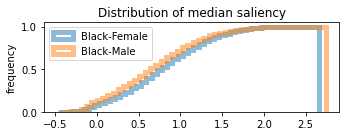

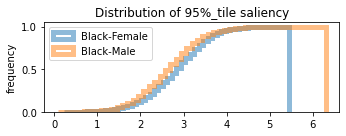

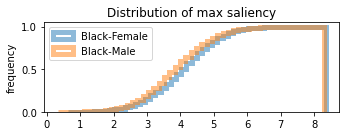

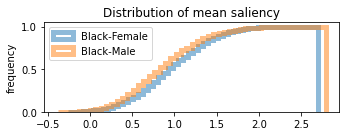

In [121]:
group_to_plot = [("Black", "Female"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="black",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

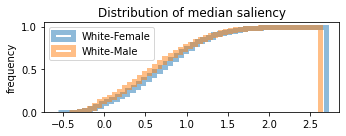

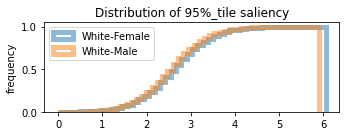

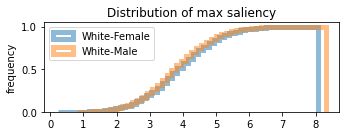

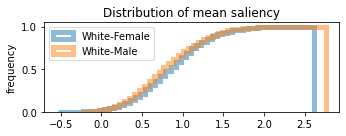

In [122]:
group_to_plot = [("White", "Female"), ("White", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

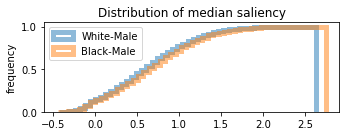

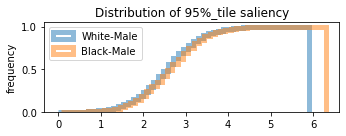

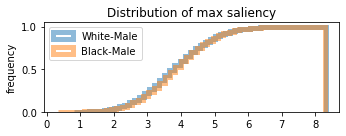

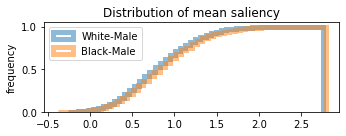

In [123]:
group_to_plot = [("White", "Male"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

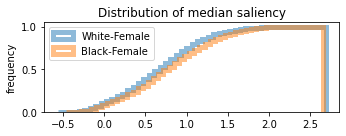

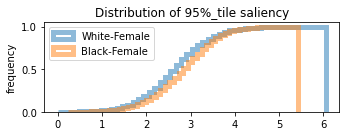

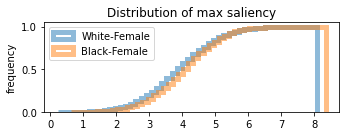

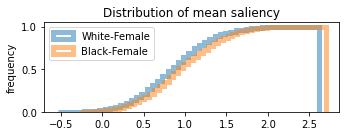

In [124]:
group_to_plot = [("White", "Female"), ("Black", "Female")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

## 4. Demographic Bias Analysis FairFace with Luxury Watches Artifacts

In [125]:
black_df = df[df["race"] == "Black"]
white_df = df[df["race"] == "White"]
black_male_df = black_df[black_df["gender"] == "Male"]
black_female_df = black_df[black_df["gender"] == "Female"]
white_male_df = white_df[white_df["gender"] == "Male"]
white_female_df = white_df[white_df["gender"] == "Female"]

In [ ]:
# #Create Images with watches artifacts

# luxury_watches_artifacts = glob.glob("../data/artifacts/luxury-watches/*.png")

# !mkdir "../data/fairface/manipulated"


# d_path = "../data/fairface/manipulated/black-male-luxury-watches"
# !mkdir "../data/fairface/manipulated/black-male-luxury-watches"
# ims = list(black_male_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = luxury_watches_artifacts[int(random.uniform(0, len(luxury_watches_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/white-male-luxury-watches"
# !mkdir "../data/fairface/manipulated/white-male-luxury-watches"
# ims = list(white_male_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = luxury_watches_artifacts[int(random.uniform(0, len(luxury_watches_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/white-female-luxury-watches"
# !mkdir "../data/fairface/manipulated/white-female-luxury-watches"
# ims = list(white_female_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = luxury_watches_artifacts[int(random.uniform(0, len(luxury_watches_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/black-female-luxury-watches"
# !mkdir "../data/fairface/manipulated/black-female-luxury-watches"
# ims = list(black_female_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = luxury_watches_artifacts[int(random.uniform(0, len(luxury_watches_artifacts)))]
#     create_manipulated_image(img, artif, d_path)

In [126]:
def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-luxury-watches/{img_name}"
    
    return new_path

black_male_df["path"] = black_male_df["path"].apply(change_path)


def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-luxury-watches/{img_name}"
    
    return new_path

white_male_df["path"] = white_male_df["path"].apply(change_path)

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-luxury-watches/{img_name}"
    
    return new_path

black_female_df["path"] = black_female_df["path"].apply(change_path)

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-luxury-watches/{img_name}"
    
    return new_path

white_female_df["path"] = white_female_df["path"].apply(change_path)


/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [127]:
df2 = pd.concat([black_male_df, white_male_df, black_female_df, white_female_df], sort=True)
df2 = df2.sort_index()

In [128]:
grouped_images_dict = get_grouped_images(
    df2, by_columns=["race", "gender"]
)

('Black', 'Female')
Size of the group: 3104
('Black', 'Male')
Size of the group: 2942
('White', 'Female')
Size of the group: 4500
('White', 'Male')
Size of the group: 4769


In [129]:
grouped_images_dict.keys()

dict_keys([('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male')])

In [130]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

True

In [131]:
RESULT_FILE_PATH = data_dir / "./fairface_2race_watches_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

True

In [132]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)

In [133]:
#Analysis

# change the setting here
NUM_ITERATION = 500
FIXED_HEIGHT = (
    256
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "fairface_2race_watches_fixed_height_intersect"  # for saving results and plots

In [134]:
all_race_to_compare = list(grouped_images_dict.keys())
all_pairs_replicate_ori = [
    (all_race_to_compare[i], all_race_to_compare[j])
    for i in range(len(all_race_to_compare))
    for j in range(i + 1, len(all_race_to_compare))
]

In [135]:
max_salient_compare_dict = {}

for pair in all_pairs_replicate_ori:
    max_salient_compare_dict[pair] = compute_comparison_from_group_name(
        grouped_images_dict,
        pair,
        num_iterations=NUM_ITERATION,
        save_setting=SETTING_NAME,
        fixed_height=FIXED_HEIGHT,
        pixel_size_upperbound=DIM_BOUND,
    )

100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('Black', 'Male'))
The statistic is: [279. 221.]
Size of the sample: 500
total time used: 203.70335459709167 seconds.
time used per comparison: 0.40740670919418337 seconds.
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('White', 'Female'))
The statistic is: [246. 254.]
Size of the sample: 500
total time used: 191.03687262535095 seconds.
time used per comparison: 0.3820737452507019 seconds.
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling 

In [136]:
max_salient_compare_dict

{(('Black', 'Female'), ('Black', 'Male')): array([279., 221.]),
 (('Black', 'Female'), ('White', 'Female')): array([246., 254.]),
 (('Black', 'Female'), ('White', 'Male')): array([267., 233.]),
 (('Black', 'Male'), ('White', 'Female')): array([222., 278.]),
 (('Black', 'Male'), ('White', 'Male')): array([217., 283.]),
 (('White', 'Female'), ('White', 'Male')): array([247., 253.])}

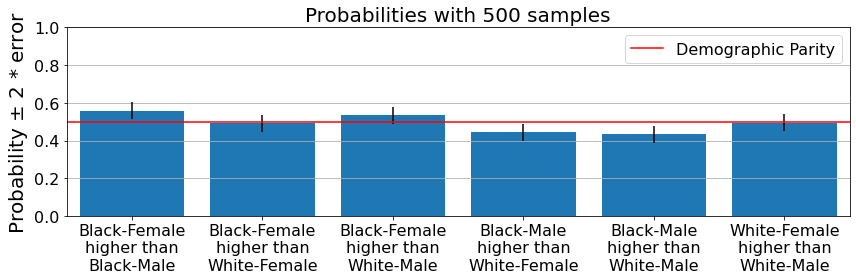

In [137]:
plot_pairwise_stats(
    max_salient_compare_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(12, 4),
    x_label_angle=0,
)

In [138]:
# change the setting here
NUM_ITERATION = 2000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept

In [139]:
group_name_list = [('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male')]

SETTING_NAME = "fairface_2race_watches_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 2000 iterations of sampling has been done.
200 / 2000 iterations of sampling has been done.
300 / 2000 iterations of sampling has been done.
400 / 2000 iterations of sampling has been done.
500 / 2000 iterations of sampling has been done.
600 / 2000 iterations of sampling has been done.
700 / 2000 iterations of sampling has been done.
800 / 2000 iterations of sampling has been done.
900 / 2000 iterations of sampling has been done.
1000 / 2000 iterations of sampling has been done.
1100 / 2000 iterations of sampling has been done.
1200 / 2000 iterations of sampling has been done.
1300 / 2000 iterations of sampling has been done.
1400 / 2000 iterations of sampling has been done.
1500 / 2000 iterations of sampling has been done.
1600 / 2000 iterations of sampling has been done.
1700 / 2000 iterations of sampling has been done.
1800 / 2000 iterations of sampling has been done.
1900 / 2000 iterations of sampling has been done.
2000 / 2000 iterations of sampling has been done.
The group

In [140]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(group_name_list, max_salient_all_groups_stats)
}

['Black-Female', 'Black-Male', 'White-Female', 'White-Male']
<class 'numpy.float64'> <class 'list'>


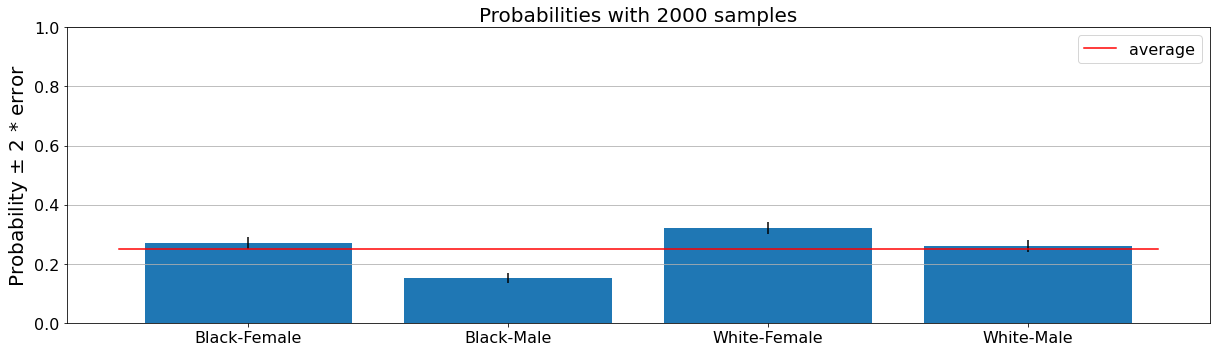

In [141]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [142]:
# change the setting here
NUM_ITERATION = 500  # None # None if want to do whole thing
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "faiface_2race_watches_no_scaling_intersect_stat"  # for saving results and plots

In [143]:
all_stats_dict = {}
for key in grouped_images_dict.keys():
    print("Computing stats for:", key)
    file_path_list = grouped_images_dict[key].path.values.tolist()
    all_stats_dict[key] = compute_saliency_stats(
        file_path_list,
        sample=NUM_ITERATION,
        percentile_queries=[50, 95, 100],
        fixed_height=None,
        pixel_size_upperbound=None,
        save_dir=SAVE_DIR_ATTACHED,
        log_every=100,
        print_summary=True,
    )

Computing stats for: ('Black', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 251.91209506988525 seconds.
time used per comparison: 0.5038241901397705 seconds.
Computing stats for: ('Black', 'Male')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 253.0389268398285 seconds.
time used per comparison: 0.506077853679657 seconds.
Computing stats for: ('White', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 246.28003025054932 seconds.
time use

In [144]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["100%_tile"].values,
                all_stats_dict[group_list[j]]["100%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5311520000000003
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5214919999999994
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.5151720000000002
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.49022000000000066
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.4856719999999991
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.49491599999999947


In [145]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["95%_tile"].values,
                all_stats_dict[group_list[j]]["95%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.545971999999999
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5454159999999992
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.5658800000000008
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.500488
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.5205439999999999
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.520132


In [146]:
for (g1, g2), df_t in all_stats_dict.items():
    out_path = f"./fairface_2race_watches_all_stats_dict_{g1}_{g2}.tsv"
    print(out_path)
    df_t.to_csv(out_path, sep="\t")

./fairface_2race_watches_all_stats_dict_Black_Female.tsv
./fairface_2race_watches_all_stats_dict_Black_Male.tsv
./fairface_2race_watches_all_stats_dict_White_Female.tsv
./fairface_2race_watches_all_stats_dict_White_Male.tsv


In [147]:
print(f"Setting = {SETTING_NAME}")

Setting = faiface_2race_watches_no_scaling_intersect_stat


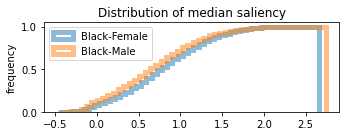

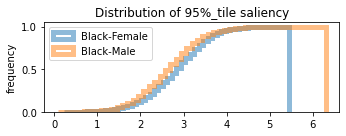

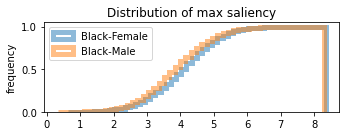

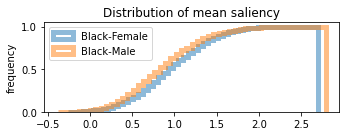

In [148]:
group_to_plot = [("Black", "Female"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="black",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

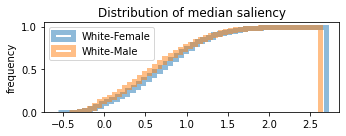

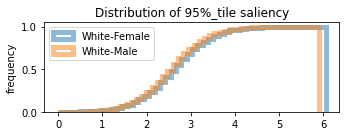

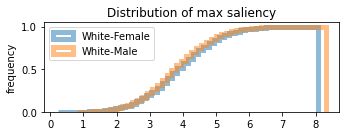

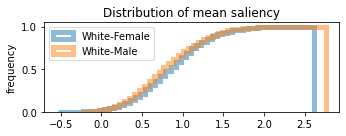

In [149]:
group_to_plot = [("White", "Female"), ("White", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

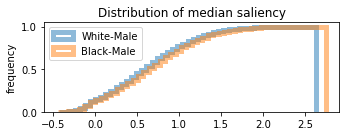

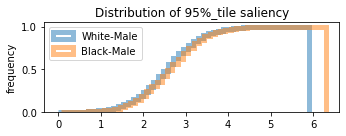

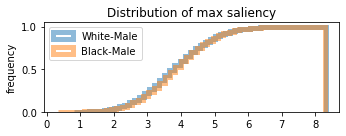

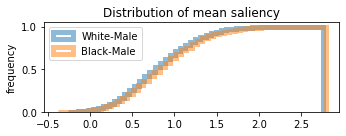

In [150]:
group_to_plot = [("White", "Male"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

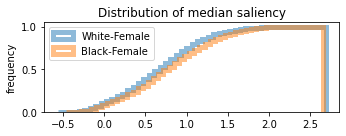

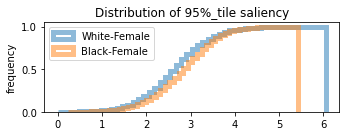

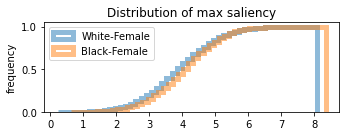

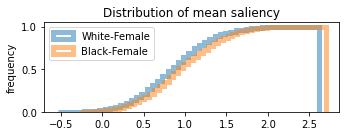

In [151]:
group_to_plot = [("White", "Female"), ("Black", "Female")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

## 5. Demographic Bias Analysis FairFace with Cheap and Luxury Cars Artifacts

In [210]:
black_df = df[df["race"] == "Black"]
white_df = df[df["race"] == "White"]
black_male_df = black_df[black_df["gender"] == "Male"]
black_female_df = black_df[black_df["gender"] == "Female"]
white_male_df = white_df[white_df["gender"] == "Male"]
white_female_df = white_df[white_df["gender"] == "Female"]

In [211]:
# #Create Images with cheap cars artifacts

# cheap_cars_artifacts = glob.glob("../data/artifacts/cheap-cars/*.png")

# !mkdir "../data/fairface/manipulated"


# d_path = "../data/fairface/manipulated/black-male-cheap-cars"
# !mkdir "../data/fairface/manipulated/black-male-cheap-cars"
# ims = list(black_male_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = cheap_cars_artifacts[int(random.uniform(0, len(cheap_cars_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/white-male-cheap-cars"
# !mkdir "../data/fairface/manipulated/white-male-cheap-cars"
# ims = list(white_male_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = cheap_cars_artifacts[int(random.uniform(0, len(cheap_cars_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/white-female-cheap-cars"
# !mkdir "../data/fairface/manipulated/white-female-cheap-cars"
# ims = list(white_female_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = cheap_cars_artifacts[int(random.uniform(0, len(cheap_cars_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/black-female-cheap-cars"
# !mkdir "../data/fairface/manipulated/black-female-cheap-cars"
# ims = list(black_female_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = cheap_cars_artifacts[int(random.uniform(0, len(cheap_cars_artifacts)))]
#     create_manipulated_image(img, artif, d_path)

In [212]:
def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-cheap-cars/{img_name}"
    
    return new_path

black_male_df["path"] = black_male_df["path"].apply(change_path)


def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-cheap-cars/{img_name}"
    
    return new_path

white_male_df["path"] = white_male_df["path"].apply(change_path)

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-cheap-cars/{img_name}"
    
    return new_path

black_female_df["path"] = black_female_df["path"].apply(change_path)

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-cheap-cars/{img_name}"
    
    return new_path

white_female_df["path"] = white_female_df["path"].apply(change_path)


/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [213]:
df2 = pd.concat([black_male_df, white_male_df, black_female_df, white_female_df], sort=True)
df2 = df2.sort_index()
df2

,RGB,age,faces,file,gender,path,race,service_test
2,True,20-29,1,train/6.jpg,Male,../data/fairface/manipulated/white-male-cheap-...,White,True
5,True,30-39,1,train/16.jpg,Female,../data/fairface/manipulated/white-female-chea...,White,False
7,True,20-29,0,train/23.jpg,Female,../data/fairface/manipulated/black-female-chea...,Black,True
8,True,30-39,1,train/24.jpg,Female,../data/fairface/manipulated/white-female-chea...,White,False
9,True,30-39,1,train/26.jpg,Female,../data/fairface/manipulated/black-female-chea...,Black,True
...,...,...,...,...,...,...,...,...
27817,True,40-49,1,train/86712.jpg,Female,../data/fairface/manipulated/white-female-chea...,White,False
27821,True,40-49,1,train/86727.jpg,Female,../data/fairface/manipulated/white-female-chea...,White,True
27823,True,40-49,1,train/86733.jpg,Female,../data/fairface/manipulated/white-female-chea...,White,False
27824,True,20-29,1,train/86737.jpg,Male,../data/fairface/manipulated/black-male-cheap-...,Black,False


In [214]:
grouped_images_dict = get_grouped_images(
    df2, by_columns=["race", "gender"]
)

('Black', 'Female')
Size of the group: 3104
('Black', 'Male')
Size of the group: 2942
('White', 'Female')
Size of the group: 4500
('White', 'Male')
Size of the group: 4769


In [215]:
grouped_images_dict.keys()

dict_keys([('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male')])

In [216]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

True

In [217]:
RESULT_FILE_PATH = data_dir / "./fairface_2race_cheap_cars_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

True

In [218]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)

In [219]:
#Analysis

# change the setting here
NUM_ITERATION = 500
FIXED_HEIGHT = (
    256
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "fairface_2race_cheap_cars_fixed_height_intersect"  # for saving results and plots

In [220]:
all_race_to_compare = list(grouped_images_dict.keys())
all_pairs_replicate_ori = [
    (all_race_to_compare[i], all_race_to_compare[j])
    for i in range(len(all_race_to_compare))
    for j in range(i + 1, len(all_race_to_compare))
]

In [221]:
max_salient_compare_dict = {}

for pair in all_pairs_replicate_ori:
    max_salient_compare_dict[pair] = compute_comparison_from_group_name(
        grouped_images_dict,
        pair,
        num_iterations=NUM_ITERATION,
        save_setting=SETTING_NAME,
        fixed_height=FIXED_HEIGHT,
        pixel_size_upperbound=DIM_BOUND,
    )

100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('Black', 'Male'))
The statistic is: [291. 209.]
Size of the sample: 500
total time used: 288.16424441337585 seconds.
time used per comparison: 0.5763284888267517 seconds.
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('White', 'Female'))
The statistic is: [247. 253.]
Size of the sample: 500
total time used: 212.96078944206238 seconds.
time used per comparison: 0.42592157888412474 seconds.
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling 

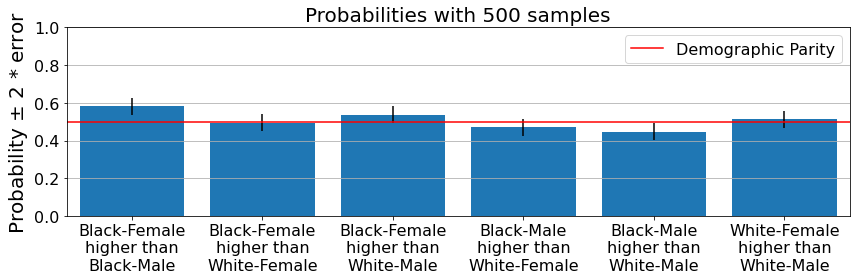

In [222]:
plot_pairwise_stats(
    max_salient_compare_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(12, 4),
    x_label_angle=0,
)

In [223]:
# change the setting here
NUM_ITERATION = 2000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept

In [224]:
group_name_list = [('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male')]

SETTING_NAME = "fairface_2race_cheap_cars_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 2000 iterations of sampling has been done.
200 / 2000 iterations of sampling has been done.
300 / 2000 iterations of sampling has been done.
400 / 2000 iterations of sampling has been done.
500 / 2000 iterations of sampling has been done.
600 / 2000 iterations of sampling has been done.
700 / 2000 iterations of sampling has been done.
800 / 2000 iterations of sampling has been done.
900 / 2000 iterations of sampling has been done.
1000 / 2000 iterations of sampling has been done.
1100 / 2000 iterations of sampling has been done.
1200 / 2000 iterations of sampling has been done.
1300 / 2000 iterations of sampling has been done.
1400 / 2000 iterations of sampling has been done.
1500 / 2000 iterations of sampling has been done.
1600 / 2000 iterations of sampling has been done.
1700 / 2000 iterations of sampling has been done.
1800 / 2000 iterations of sampling has been done.
1900 / 2000 iterations of sampling has been done.
2000 / 2000 iterations of sampling has been done.
The group

In [225]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(group_name_list, max_salient_all_groups_stats)
}

['Black-Female', 'Black-Male', 'White-Female', 'White-Male']
<class 'numpy.float64'> <class 'list'>


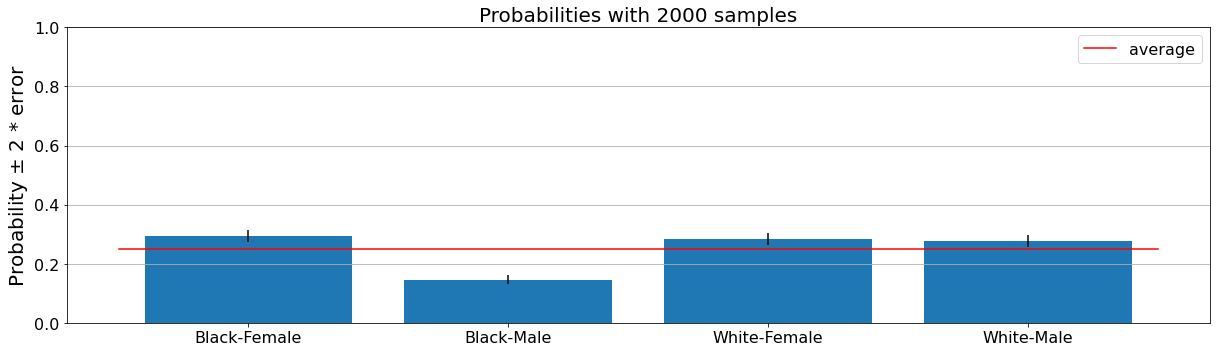

In [226]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [227]:
# change the setting here
NUM_ITERATION = 500  # None # None if want to do whole thing
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "faiface_2race_cheap_cars_no_scaling_intersect_stat"  # for saving results and plots

In [228]:
all_stats_dict = {}
for key in grouped_images_dict.keys():
    print("Computing stats for:", key)
    file_path_list = grouped_images_dict[key].path.values.tolist()
    all_stats_dict[key] = compute_saliency_stats(
        file_path_list,
        sample=NUM_ITERATION,
        percentile_queries=[50, 95, 100],
        fixed_height=None,
        pixel_size_upperbound=None,
        save_dir=SAVE_DIR_ATTACHED,
        log_every=100,
        print_summary=True,
    )

Computing stats for: ('Black', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 359.7972707748413 seconds.
time used per comparison: 0.7195945415496826 seconds.
Computing stats for: ('Black', 'Male')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 281.89138102531433 seconds.
time used per comparison: 0.5637827620506287 seconds.
Computing stats for: ('White', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 313.54479718208313 seconds.
time us

In [229]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["100%_tile"].values,
                all_stats_dict[group_list[j]]["100%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.515084
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5482279999999999
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.5015559999999999
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.5302760000000009
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.48607599999999884
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.45367599999999986


In [230]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["95%_tile"].values,
                all_stats_dict[group_list[j]]["95%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5414239999999992
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.571444
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.5396639999999997
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.5295439999999999
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.4976599999999999
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.4677560000000005


In [231]:
for (g1, g2), df_t in all_stats_dict.items():
    out_path = f"./fairface_2race_cheap_cars_all_stats_dict_{g1}_{g2}.tsv"
    print(out_path)
    df_t.to_csv(out_path, sep="\t")

./fairface_2race_cheap_cars_all_stats_dict_Black_Female.tsv
./fairface_2race_cheap_cars_all_stats_dict_Black_Male.tsv
./fairface_2race_cheap_cars_all_stats_dict_White_Female.tsv
./fairface_2race_cheap_cars_all_stats_dict_White_Male.tsv


In [232]:
print(f"Setting = {SETTING_NAME}")

Setting = faiface_2race_cheap_cars_no_scaling_intersect_stat


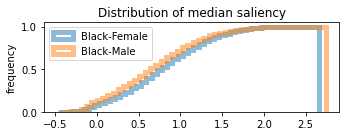

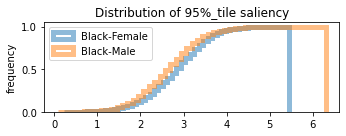

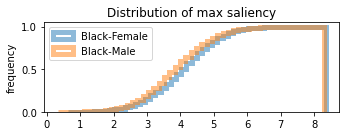

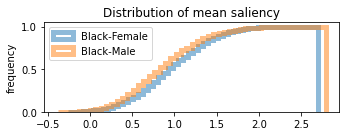

In [233]:
group_to_plot = [("Black", "Female"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="black",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

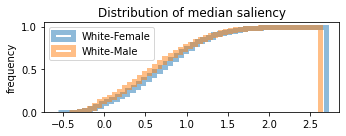

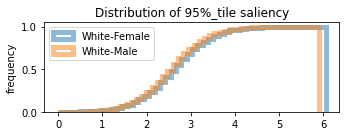

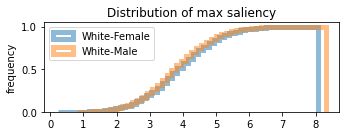

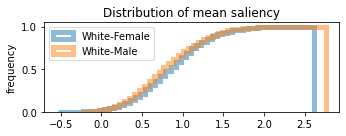

In [234]:
group_to_plot = [("White", "Female"), ("White", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

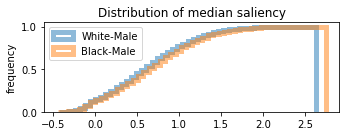

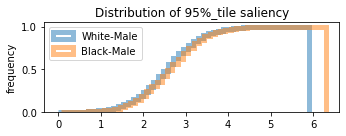

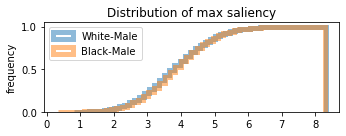

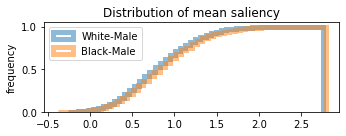

In [235]:
group_to_plot = [("White", "Male"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

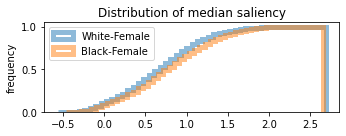

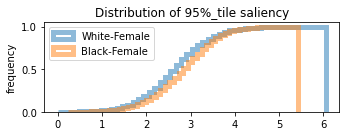

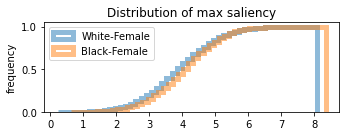

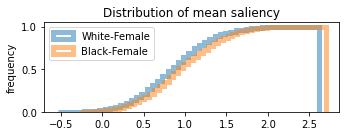

In [236]:
group_to_plot = [("White", "Female"), ("Black", "Female")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

In [ ]:
#Luxury cars

In [237]:
black_df = df[df["race"] == "Black"]
white_df = df[df["race"] == "White"]
black_male_df = black_df[black_df["gender"] == "Male"]
black_female_df = black_df[black_df["gender"] == "Female"]
white_male_df = white_df[white_df["gender"] == "Male"]
white_female_df = white_df[white_df["gender"] == "Female"]

In [183]:
# #Create Images with luxury cars artifacts

# luxury_cars_artifacts = glob.glob("../data/artifacts/luxury-cars/*.png")

# !mkdir "../data/fairface/manipulated"


# d_path = "../data/fairface/manipulated/black-male-luxury-cars"
# !mkdir "../data/fairface/manipulated/black-male-luxury-cars"
# ims = list(black_male_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = luxury_cars_artifacts[int(random.uniform(0, len(luxury_cars_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/white-male-luxury-cars"
# !mkdir "../data/fairface/manipulated/white-male-luxury-cars"
# ims = list(white_male_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = luxury_cars_artifacts[int(random.uniform(0, len(luxury_cars_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/white-female-luxury-cars"
# !mkdir "../data/fairface/manipulated/white-female-luxury-cars"
# ims = list(white_female_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = luxury_cars_artifacts[int(random.uniform(0, len(luxury_cars_artifacts)))]
#     create_manipulated_image(img, artif, d_path)
    
# d_path = "../data/fairface/manipulated/black-female-luxury-cars"
# !mkdir "../data/fairface/manipulated/black-female-luxury-cars"
# ims = list(black_female_df["path"].values)

# print("Making manipulated image...")
# for img in tqdm(ims, total=len(ims)):
#     artif = luxury_cars_artifacts[int(random.uniform(0, len(luxury_cars_artifacts)))]
#     create_manipulated_image(img, artif, d_path)

mkdir: cannot create directory ‘../data/fairface/manipulated’: File exists
mkdir: cannot create directory ‘../data/fairface/manipulated/black-male-luxury-cars’: File exists
Making manipulated image...


100%|██████████| 2942/2942 [02:39<00:00, 18.39it/s]


Making manipulated image...


100%|██████████| 4769/4769 [04:32<00:00, 17.48it/s]


Making manipulated image...


100%|██████████| 4500/4500 [04:22<00:00, 17.15it/s]


Making manipulated image...


100%|██████████| 3104/3104 [02:50<00:00, 18.17it/s]


In [238]:
def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-luxury-cars/{img_name}"
    
    return new_path

black_male_df["path"] = black_male_df["path"].apply(change_path)


def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-luxury-cars/{img_name}"
    
    return new_path

white_male_df["path"] = white_male_df["path"].apply(change_path)

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-luxury-cars/{img_name}"
    
    return new_path

black_female_df["path"] = black_female_df["path"].apply(change_path)

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-luxury-cars/{img_name}"
    
    return new_path

white_female_df["path"] = white_female_df["path"].apply(change_path)


/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [239]:
df2 = pd.concat([black_male_df, white_male_df, black_female_df, white_female_df], sort=True)
df2 = df2.sort_index()

grouped_images_dict = get_grouped_images(
    df2, by_columns=["race", "gender"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./fairface_2race_luxury_cars_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
#Analysis

# change the setting here
NUM_ITERATION = 500
FIXED_HEIGHT = (
    256
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "fairface_2race_luxury_cars_fixed_height_intersect"  # for saving results and plots

all_race_to_compare = list(grouped_images_dict.keys())
all_pairs_replicate_ori = [
    (all_race_to_compare[i], all_race_to_compare[j])
    for i in range(len(all_race_to_compare))
    for j in range(i + 1, len(all_race_to_compare))
]

max_salient_compare_dict = {}

for pair in all_pairs_replicate_ori:
    max_salient_compare_dict[pair] = compute_comparison_from_group_name(
        grouped_images_dict,
        pair,
        num_iterations=NUM_ITERATION,
        save_setting=SETTING_NAME,
        fixed_height=FIXED_HEIGHT,
        pixel_size_upperbound=DIM_BOUND,
    )

('Black', 'Female')
Size of the group: 3104
('Black', 'Male')
Size of the group: 2942
('White', 'Female')
Size of the group: 4500
('White', 'Male')
Size of the group: 4769
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('Black', 'Male'))
The statistic is: [265. 235.]
Size of the sample: 500
total time used: 230.08907914161682 seconds.
time used per comparison: 0.46017815828323366 seconds.
100 / 500 iterations of sampling has been done.
200 / 500 iterations of sampling has been done.
300 / 500 iterations of sampling has been done.
400 / 500 iterations of sampling has been done.
500 / 500 iterations of sampling has been done.
The groups entered are: (('Black', 'Female'), ('White', 'Female'))
The statistic is: [248. 252.]
Size of the sample: 500
total ti

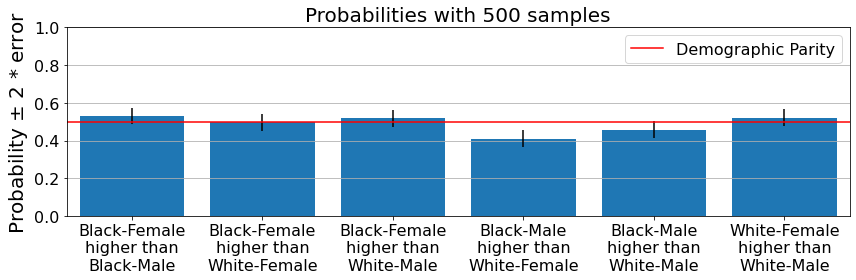

In [240]:
plot_pairwise_stats(
    max_salient_compare_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(12, 4),
    x_label_angle=0,
)

In [241]:
# change the setting here
NUM_ITERATION = 2000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept

group_name_list = [('Black', 'Female'), ('Black', 'Male'), ('White', 'Female'), ('White', 'Male')]

SETTING_NAME = "fairface_2race_luxury_cars_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(group_name_list, max_salient_all_groups_stats)
}

100 / 2000 iterations of sampling has been done.
200 / 2000 iterations of sampling has been done.
300 / 2000 iterations of sampling has been done.
400 / 2000 iterations of sampling has been done.
500 / 2000 iterations of sampling has been done.
600 / 2000 iterations of sampling has been done.
700 / 2000 iterations of sampling has been done.
800 / 2000 iterations of sampling has been done.
900 / 2000 iterations of sampling has been done.
1000 / 2000 iterations of sampling has been done.
1100 / 2000 iterations of sampling has been done.
1200 / 2000 iterations of sampling has been done.
1300 / 2000 iterations of sampling has been done.
1400 / 2000 iterations of sampling has been done.
1500 / 2000 iterations of sampling has been done.
1600 / 2000 iterations of sampling has been done.
1700 / 2000 iterations of sampling has been done.
1800 / 2000 iterations of sampling has been done.
1900 / 2000 iterations of sampling has been done.
2000 / 2000 iterations of sampling has been done.
The group

['Black-Female', 'Black-Male', 'White-Female', 'White-Male']
<class 'numpy.float64'> <class 'list'>


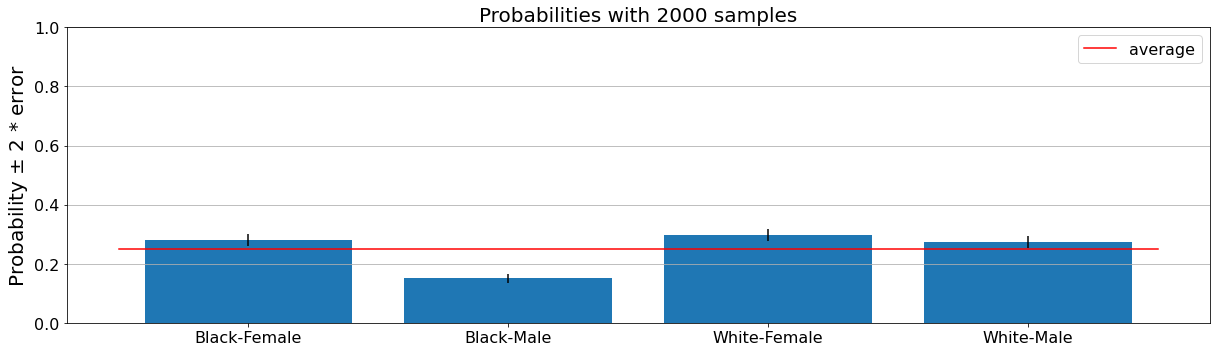

In [242]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [243]:
# change the setting here
NUM_ITERATION = 500  # None # None if want to do whole thing
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "faiface_2race_luury_cars_no_scaling_intersect_stat"  # for saving results and plots


all_stats_dict = {}
for key in grouped_images_dict.keys():
    print("Computing stats for:", key)
    file_path_list = grouped_images_dict[key].path.values.tolist()
    all_stats_dict[key] = compute_saliency_stats(
        file_path_list,
        sample=NUM_ITERATION,
        percentile_queries=[50, 95, 100],
        fixed_height=None,
        pixel_size_upperbound=None,
        save_dir=SAVE_DIR_ATTACHED,
        log_every=100,
        print_summary=True,
    )

Computing stats for: ('Black', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 273.095801115036 seconds.
time used per comparison: 0.546191602230072 seconds.
Computing stats for: ('Black', 'Male')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 275.8191032409668 seconds.
time used per comparison: 0.5516382064819336 seconds.
Computing stats for: ('White', 'Female')
100 iterations of sampling has been done.
200 iterations of sampling has been done.
300 iterations of sampling has been done.
400 iterations of sampling has been done.
500 iterations of sampling has been done.
total time used: 266.7520580291748 seconds.
time used p

In [244]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["100%_tile"].values,
                all_stats_dict[group_list[j]]["100%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5397039999999997
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5094480000000001
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.5273320000000004
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.4719919999999994
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.48717200000000027
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.5154400000000008


In [245]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["95%_tile"].values,
                all_stats_dict[group_list[j]]["95%_tile"].values,
            ),
        )

Probability that group ('Black', 'Female') >= ('Black', 'Male') is 0.5644279999999998
Probability that group ('Black', 'Female') >= ('White', 'Female') is 0.5671599999999994
Probability that group ('Black', 'Female') >= ('White', 'Male') is 0.5710200000000007
Probability that group ('Black', 'Male') >= ('White', 'Female') is 0.5051999999999991
Probability that group ('Black', 'Male') >= ('White', 'Male') is 0.5061920000000002
Probability that group ('White', 'Female') >= ('White', 'Male') is 0.4998840000000002


In [246]:
for (g1, g2), df_t in all_stats_dict.items():
    out_path = f"./fairface_2race_luxury_cars_all_stats_dict_{g1}_{g2}.tsv"
    print(out_path)
    df_t.to_csv(out_path, sep="\t")

./fairface_2race_luxury_cars_all_stats_dict_Black_Female.tsv
./fairface_2race_luxury_cars_all_stats_dict_Black_Male.tsv
./fairface_2race_luxury_cars_all_stats_dict_White_Female.tsv
./fairface_2race_luxury_cars_all_stats_dict_White_Male.tsv


In [247]:
print(f"Setting = {SETTING_NAME}")

Setting = faiface_2race_luury_cars_no_scaling_intersect_stat


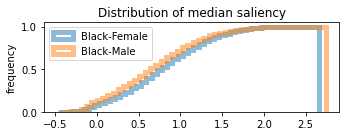

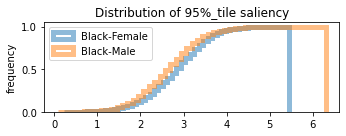

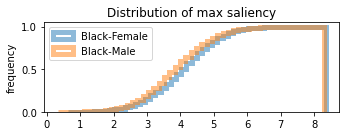

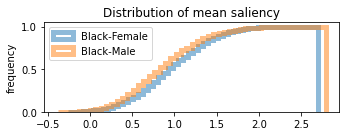

In [248]:
group_to_plot = [("Black", "Female"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="black",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

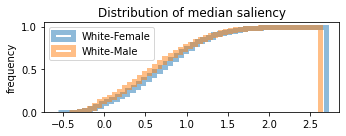

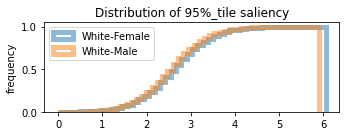

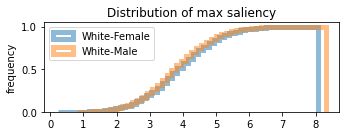

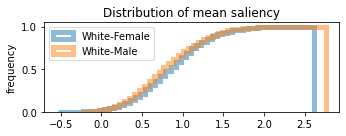

In [249]:
group_to_plot = [("White", "Female"), ("White", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

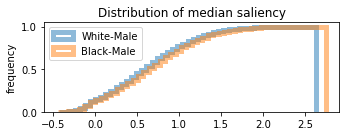

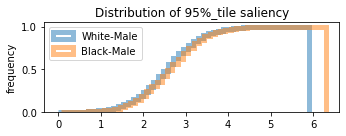

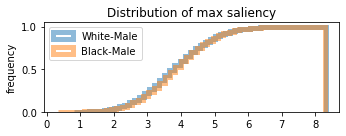

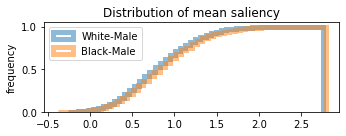

In [250]:
group_to_plot = [("White", "Male"), ("Black", "Male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

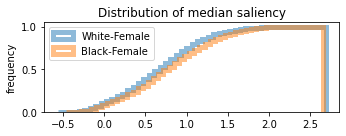

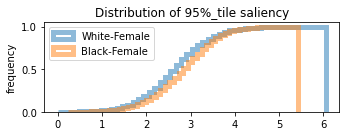

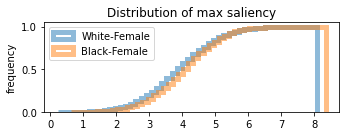

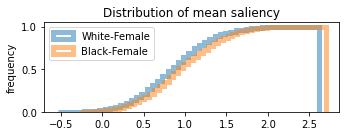

In [251]:
group_to_plot = [("White", "Female"), ("Black", "Female")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

## Creating manipulated images for swiss army knives, lipsticks and cheerleading poms

In [197]:
black_df = df[df["race"] == "Black"]
white_df = df[df["race"] == "White"]
black_male_df = black_df[black_df["gender"] == "Male"]
black_female_df = black_df[black_df["gender"] == "Female"]
white_male_df = white_df[white_df["gender"] == "Male"]
white_female_df = white_df[white_df["gender"] == "Female"]

In [199]:
#Create Images with swiss army knife artifacts

artifs = glob.glob("../data/artifacts/swiss-army-knives/*.png")

!mkdir "../data/fairface/manipulated"


d_path = "../data/fairface/manipulated/black-male-swiss-army-knives"
!mkdir "../data/fairface/manipulated/black-male-swiss-army-knives"
ims = list(black_male_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)
    
d_path = "../data/fairface/manipulated/white-male-swiss-army-knives"
!mkdir "../data/fairface/manipulated/white-male-swiss-army-knives"
ims = list(white_male_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)
    
d_path = "../data/fairface/manipulated/white-female-swiss-army-knives"
!mkdir "../data/fairface/manipulated/white-female-swiss-army-knives"
ims = list(white_female_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)
    
d_path = "../data/fairface/manipulated/black-female-swiss-army-knives"
!mkdir "../data/fairface/manipulated/black-female-swiss-army-knives"
ims = list(black_female_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)

mkdir: cannot create directory ‘../data/fairface/manipulated’: File exists
Making manipulated image...


100%|██████████| 2942/2942 [03:29<00:00, 14.03it/s]


Making manipulated image...


100%|██████████| 4769/4769 [06:11<00:00, 12.82it/s]


Making manipulated image...


100%|██████████| 4500/4500 [05:55<00:00, 12.65it/s]


Making manipulated image...


100%|██████████| 3104/3104 [03:49<00:00, 13.52it/s]


In [200]:
#Create Images with lipsicks artifacts

artifs = glob.glob("../data/artifacts/lipsticks/*.png")

!mkdir "../data/fairface/manipulated"


d_path = "../data/fairface/manipulated/black-male-lipsticks"
!mkdir "../data/fairface/manipulated/black-male-lipsticks"
ims = list(black_male_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)
    
d_path = "../data/fairface/manipulated/white-male-lipsticks"
!mkdir "../data/fairface/manipulated/white-male-lipsticks"
ims = list(white_male_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)
    
d_path = "../data/fairface/manipulated/white-female-lipsticks"
!mkdir "../data/fairface/manipulated/white-female-lipsticks"
ims = list(white_female_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)
    
d_path = "../data/fairface/manipulated/black-female-lipsticks"
!mkdir "../data/fairface/manipulated/black-female-lipsticks"
ims = list(black_female_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)

mkdir: cannot create directory ‘../data/fairface/manipulated’: File exists
Making manipulated image...


100%|██████████| 2942/2942 [03:36<00:00, 13.62it/s]


Making manipulated image...


100%|██████████| 4769/4769 [06:22<00:00, 12.45it/s]


Making manipulated image...


100%|██████████| 4500/4500 [06:01<00:00, 12.45it/s]


Making manipulated image...


100%|██████████| 3104/3104 [04:05<00:00, 12.65it/s]


In [201]:
#Create Images with cheerleading-poms artifacts

artifs = glob.glob("../data/artifacts/cheerleading-poms/*.png")

!mkdir "../data/fairface/manipulated"


d_path = "../data/fairface/manipulated/black-male-cheerleading-poms"
!mkdir "../data/fairface/manipulated/black-male-cheerleading-poms"
ims = list(black_male_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)
    
d_path = "../data/fairface/manipulated/white-male-cheerleading-poms"
!mkdir "../data/fairface/manipulated/white-male-cheerleading-poms"
ims = list(white_male_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)
    
d_path = "../data/fairface/manipulated/white-female-cheerleading-poms"
!mkdir "../data/fairface/manipulated/white-female-cheerleading-poms"
ims = list(white_female_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)
    
d_path = "../data/fairface/manipulated/black-female-cheerleading-poms"
!mkdir "../data/fairface/manipulated/black-female-cheerleading-poms"
ims = list(black_female_df["path"].values)

print("Making manipulated image...")
for img in tqdm(ims, total=len(ims)):
    artif = artifs[int(random.uniform(0, len(artifs)))]
    create_manipulated_image(img, artif, d_path)

mkdir: cannot create directory ‘../data/fairface/manipulated’: File exists
Making manipulated image...


100%|██████████| 2942/2942 [06:06<00:00,  8.02it/s]


Making manipulated image...


100%|██████████| 4769/4769 [09:37<00:00,  8.26it/s]


Making manipulated image...


100%|██████████| 4500/4500 [09:20<00:00,  8.02it/s]


Making manipulated image...


100%|██████████| 3104/3104 [11:25<00:00,  4.53it/s]


In [ ]:
# Handcuffs vs Watches

In [17]:
black_df = df[df["race"] == "Black"]
white_df = df[df["race"] == "White"]

black_male_df_handcuffs = black_df[black_df["gender"] == "Male"]
black_female_df_handcuffs = black_df[black_df["gender"] == "Female"]

black_male_df_luxury_watches = black_df[black_df["gender"] == "Male"]
black_female_df_luxury_watches = black_df[black_df["gender"] == "Female"]

white_male_df_handcuffs = white_df[white_df["gender"] == "Male"]
white_female_df_handcuffs = white_df[white_df["gender"] == "Female"]

white_male_df_luxury_watches = white_df[white_df["gender"] == "Male"]
white_female_df_luxury_watches = white_df[white_df["gender"] == "Female"]

In [18]:
def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-handcuffs/{img_name}"
    
    return new_path

black_male_df_handcuffs["path"] = black_male_df_handcuffs["path"].apply(change_path)
black_male_df_handcuffs["attribute"] = "handcuff"


def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-handcuffs/{img_name}"
    
    return new_path

white_male_df_handcuffs["path"] = white_male_df_handcuffs["path"].apply(change_path)
white_male_df_handcuffs["attribute"] = "handcuff"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-handcuffs/{img_name}"
    
    return new_path

black_female_df_handcuffs["path"] = black_female_df_handcuffs["path"].apply(change_path)
black_female_df_handcuffs["attribute"] = "handcuff"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-handcuffs/{img_name}"
    
    return new_path

white_female_df_handcuffs["path"] = white_female_df_handcuffs["path"].apply(change_path)
white_female_df_handcuffs["attribute"] = "handcuff"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-luxury-watches/{img_name}"
    
    return new_path

black_male_df_luxury_watches["path"] = black_male_df_luxury_watches["path"].apply(change_path)
black_male_df_luxury_watches["attribute"] = "watches"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-luxury-watches/{img_name}"
    
    return new_path

white_male_df_luxury_watches["path"] = white_male_df_luxury_watches["path"].apply(change_path)
white_male_df_luxury_watches["attribute"] = "watches"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-luxury-watches/{img_name}"
    
    return new_path

black_female_df_luxury_watches["path"] = black_female_df_luxury_watches["path"].apply(change_path)
black_female_df_luxury_watches["attribute"] = "watches"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-luxury-watches/{img_name}"
    
    return new_path

white_female_df_luxury_watches["path"] = white_female_df_luxury_watches["path"].apply(change_path)
white_female_df_luxury_watches["attribute"] = "watches"

/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [19]:
#Black male handcuffs and luxury watches

In [20]:
df2 = pd.concat([black_male_df_handcuffs, black_male_df_luxury_watches], sort=True)
df2 = df2.sort_index()
df2

,RGB,age,attribute,faces,file,gender,path,race,service_test
17,True,20-29,handcuff,1,train/57.jpg,Male,../data/fairface/manipulated/black-male-handcu...,Black,False
17,True,20-29,watches,1,train/57.jpg,Male,../data/fairface/manipulated/black-male-luxury...,Black,False
25,True,20-29,watches,1,train/87.jpg,Male,../data/fairface/manipulated/black-male-luxury...,Black,True
25,True,20-29,handcuff,1,train/87.jpg,Male,../data/fairface/manipulated/black-male-handcu...,Black,True
28,True,20-29,handcuff,1,train/95.jpg,Male,../data/fairface/manipulated/black-male-handcu...,Black,False
...,...,...,...,...,...,...,...,...,...
27812,True,20-29,handcuff,1,train/86702.jpg,Male,../data/fairface/manipulated/black-male-handcu...,Black,True
27813,True,30-39,watches,1,train/86703.jpg,Male,../data/fairface/manipulated/black-male-luxury...,Black,True
27813,True,30-39,handcuff,1,train/86703.jpg,Male,../data/fairface/manipulated/black-male-handcu...,Black,True
27824,True,20-29,handcuff,1,train/86737.jpg,Male,../data/fairface/manipulated/black-male-handcu...,Black,False


In [23]:
# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./bm-watch-handcuff_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)

handcuff
Size of the group: 2942
watches
Size of the group: 2942


In [33]:
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "bm_watch_handcuff_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['handcuff', 'watches'])
The statistic is: [525. 475.]
Size of the sample: 1000
total time used: 373.0515742301941 seconds.
time used per comparison: 0.3730515742301941 seconds.


['h-a', 'w-a']
<class 'numpy.float64'> <class 'list'>


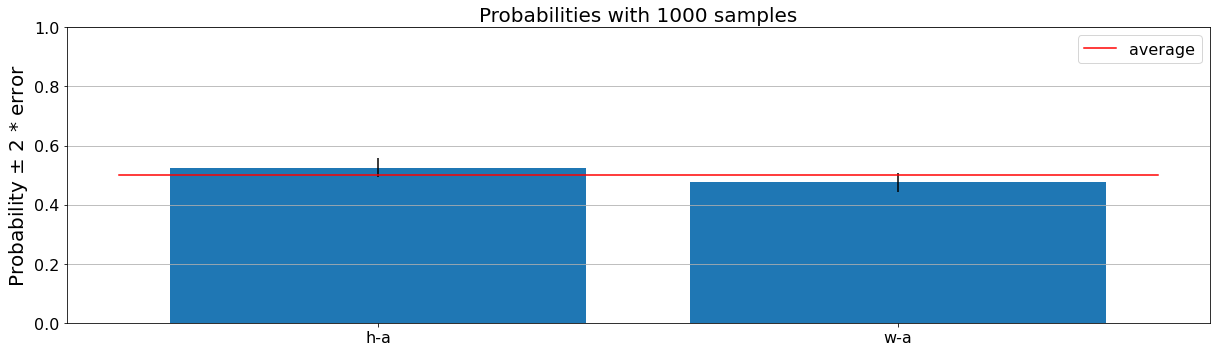

In [34]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [ ]:
#White male handcuffs and luxury watches

handcuff
Size of the group: 4769
watches
Size of the group: 4769
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['handcuff', 'watches'])
The statistic is: [502. 498.]
Size of the sample: 1000
total time used: 393.41939878463745 seconds.
time used per comparison: 0.39341939878463744 seconds.
['h-a', 'w-a']
<class 'numpy.float64'> <class 'list'>


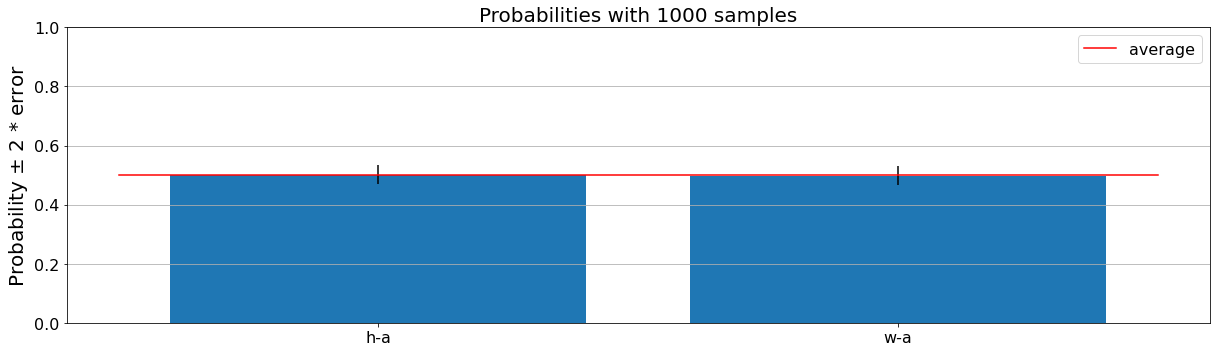

In [35]:
df2 = pd.concat([white_male_df_handcuffs, white_male_df_luxury_watches], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./wm-watch-handcuff_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "wm_watch_handcuff_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [36]:
#black female handcuff and watches

handcuff
Size of the group: 3104
watches
Size of the group: 3104
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['handcuff', 'watches'])
The statistic is: [527. 473.]
Size of the sample: 1000
total time used: 406.41242694854736 seconds.
time used per comparison: 0.40641242694854735 seconds.
['h-a', 'w-a']
<class 'numpy.float64'> <class 'list'>


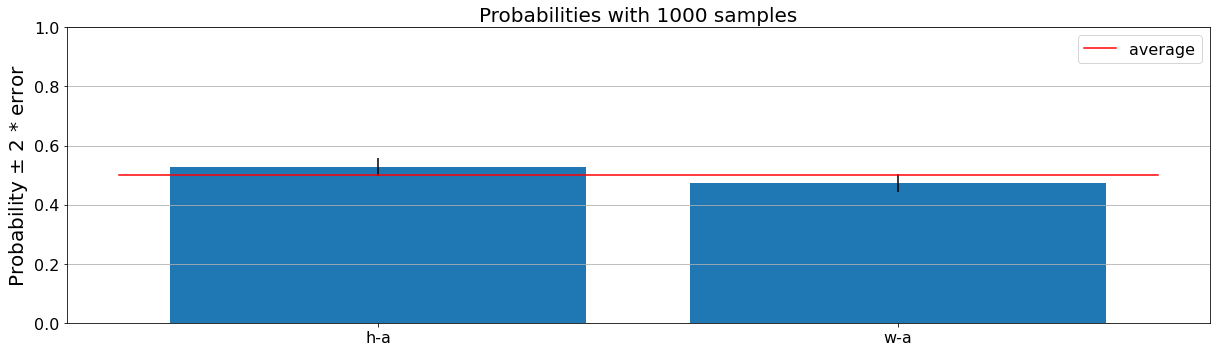

In [37]:
df2 = pd.concat([black_female_df_handcuffs, black_female_df_luxury_watches], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./bf-watch-handcuff_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "bf_watch_handcuff_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [ ]:
#white female hacndcuffs and wathes 

handcuff
Size of the group: 4500
watches
Size of the group: 4500
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['handcuff', 'watches'])
The statistic is: [481. 519.]
Size of the sample: 1000
total time used: 414.528272151947 seconds.
time used per comparison: 0.41452827215194704 seconds.
['h-a', 'w-a']
<class 'numpy.float64'> <class 'list'>


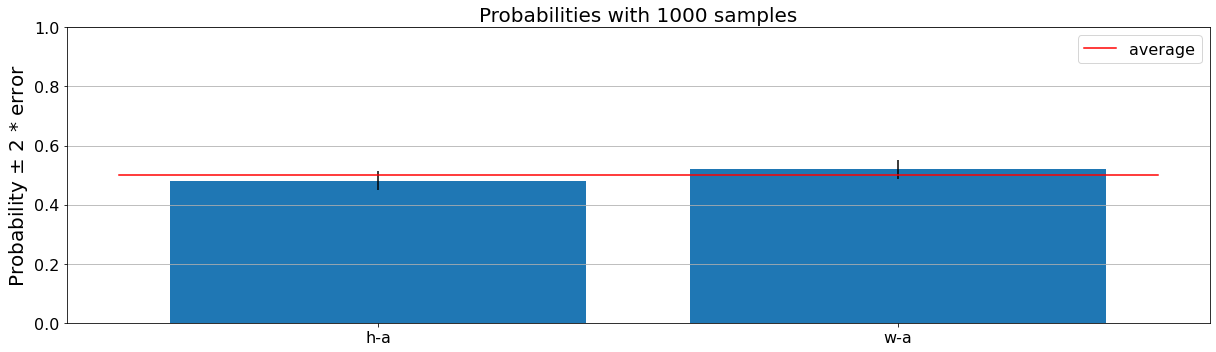

In [38]:
df2 = pd.concat([white_female_df_handcuffs, white_female_df_luxury_watches], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./wf-watch-handcuff_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "wf_watch_handcuff_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [ ]:
# Cheap cars vs Expensive Cars

In [39]:
black_df = df[df["race"] == "Black"]
white_df = df[df["race"] == "White"]

black_male_df_cheapcars = black_df[black_df["gender"] == "Male"]
black_female_df_cheapcars = black_df[black_df["gender"] == "Female"]

black_male_df_expcars = black_df[black_df["gender"] == "Male"]
black_female_df_expcars = black_df[black_df["gender"] == "Female"]

white_male_df_cheapcars = white_df[white_df["gender"] == "Male"]
white_female_df_cheapcars = white_df[white_df["gender"] == "Female"]

white_male_df_expcars = white_df[white_df["gender"] == "Male"]
white_female_df_expcars = white_df[white_df["gender"] == "Female"]

In [40]:
def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-cheap-cars/{img_name}"
    
    return new_path

black_male_df_cheapcars["path"] = black_male_df_handcuffs["path"].apply(change_path)
black_male_df_cheapcars["attribute"] = "cheapcars"


def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-cheap-cars/{img_name}"
    
    return new_path

white_male_df_cheapcars["path"] = white_male_df_handcuffs["path"].apply(change_path)
white_male_df_cheapcars["attribute"] = "cheapcars"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-cheap-cars/{img_name}"
    
    return new_path

black_female_df_cheapcars["path"] = black_female_df_handcuffs["path"].apply(change_path)
black_female_df_cheapcars["attribute"] = "cheapcars"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-cheap-cars/{img_name}"
    
    return new_path

white_female_df_cheapcars["path"] = white_female_df_handcuffs["path"].apply(change_path)
white_female_df_cheapcars["attribute"] = "cheapcars"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-luxury-cars/{img_name}"
    
    return new_path

black_male_df_expcars["path"] = black_male_df_luxury_watches["path"].apply(change_path)
black_male_df_expcars["attribute"] = "expcars"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-luxury-cars/{img_name}"
    
    return new_path

white_male_df_expcars["path"] = white_male_df_luxury_watches["path"].apply(change_path)
white_male_df_expcars["attribute"] = "expcars"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-luxury-cars/{img_name}"
    
    return new_path

black_female_df_expcars["path"] = black_female_df_luxury_watches["path"].apply(change_path)
black_female_df_expcars["attribute"] = "expcars"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-luxury-cars/{img_name}"
    
    return new_path

white_female_df_expcars["path"] = white_female_df_luxury_watches["path"].apply(change_path)
white_female_df_expcars["attribute"] = "expcars"

/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [ ]:
# Black Male cheap car and expensive car

cheapcars
Size of the group: 2942
expcars
Size of the group: 2942
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['cheapcars', 'expcars'])
The statistic is: [535. 465.]
Size of the sample: 1000
total time used: 465.5255455970764 seconds.
time used per comparison: 0.46552554559707643 seconds.
['c-h', 'e-x']
<class 'numpy.float64'> <class 'list'>


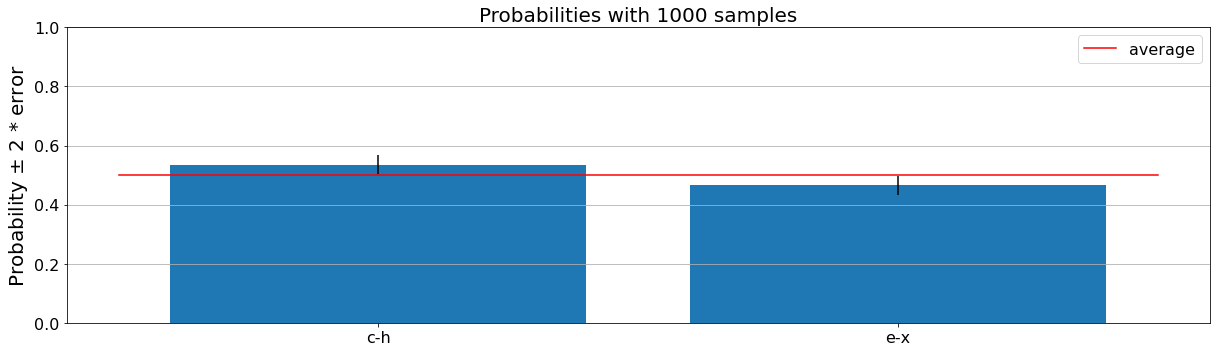

In [41]:
df2 = pd.concat([black_male_df_cheapcars, black_male_df_expcars], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./bm_cp_ec_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "bm_cp_ec_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [ ]:
# White Male cheap car and expensive car

cheapcars
Size of the group: 4769
expcars
Size of the group: 4769
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['cheapcars', 'expcars'])
The statistic is: [484. 516.]
Size of the sample: 1000
total time used: 444.0996823310852 seconds.
time used per comparison: 0.4440996823310852 seconds.
['c-h', 'e-x']
<class 'numpy.float64'> <class 'list'>


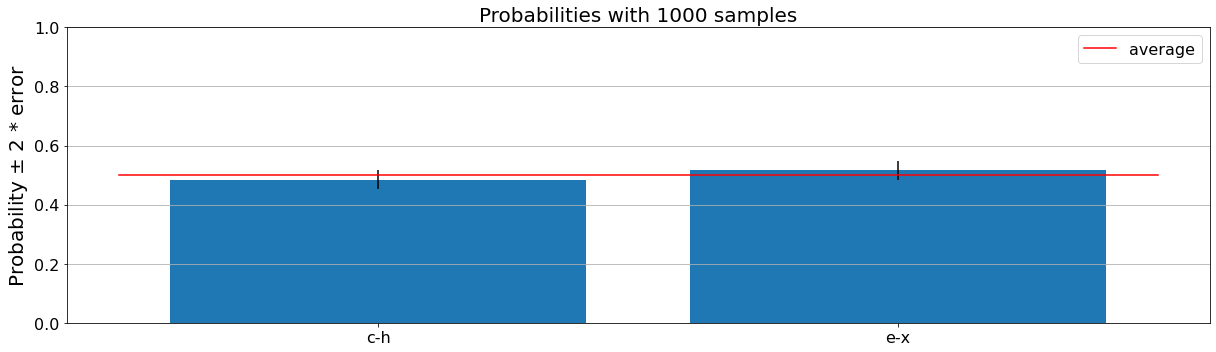

In [42]:
df2 = pd.concat([white_male_df_cheapcars, white_male_df_expcars], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./wm_cp_ec_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "wm_cp_ec_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [ ]:
# Black female cheap car and expensive car

cheapcars
Size of the group: 3104
expcars
Size of the group: 3104
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['cheapcars', 'expcars'])
The statistic is: [537. 463.]
Size of the sample: 1000
total time used: 422.0641145706177 seconds.
time used per comparison: 0.42206411457061765 seconds.
['c-h', 'e-x']
<class 'numpy.float64'> <class 'list'>


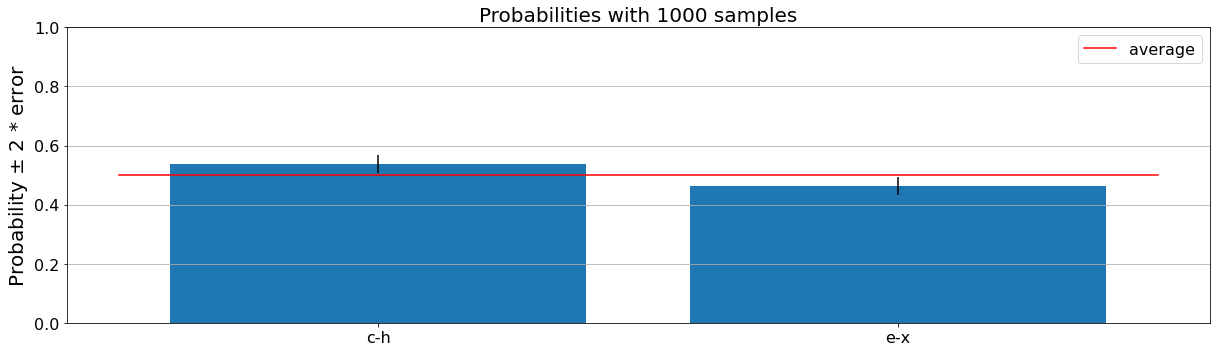

In [43]:
df2 = pd.concat([black_female_df_cheapcars, black_female_df_expcars], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./bf_cp_ec_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "bf_cp_ec_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [44]:
# White female cheap car and expensive car

cheapcars
Size of the group: 4500
expcars
Size of the group: 4500
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['cheapcars', 'expcars'])
The statistic is: [500. 500.]
Size of the sample: 1000
total time used: 444.3250012397766 seconds.
time used per comparison: 0.4443250012397766 seconds.
['c-h', 'e-x']
<class 'numpy.float64'> <class 'list'>


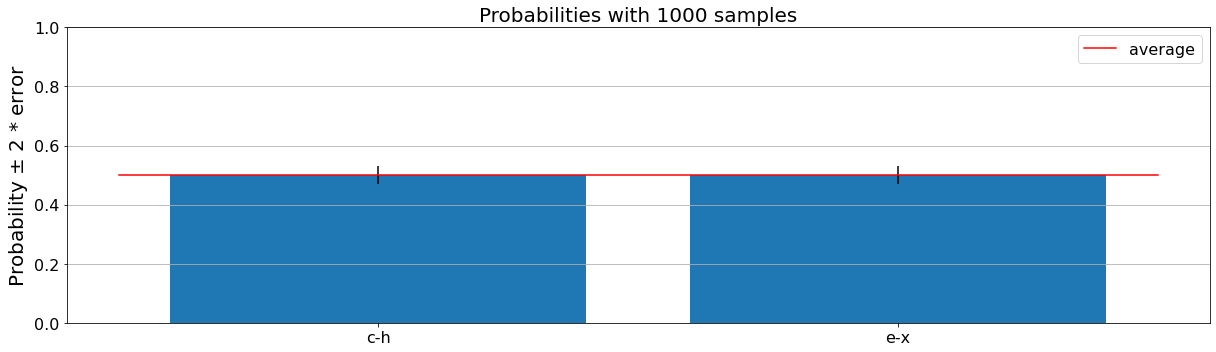

In [45]:
df2 = pd.concat([white_female_df_cheapcars, white_female_df_expcars], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./wf_cp_ec_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "wf_cp_ec_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [ ]:
#Gender biases

#Lipstick vs Swiss army knife

In [48]:
black_df = df[df["race"] == "Black"]
white_df = df[df["race"] == "White"]

black_male_df_lipstick = black_df[black_df["gender"] == "Male"]
black_female_df_lipstick = black_df[black_df["gender"] == "Female"]

black_male_df_swakife = black_df[black_df["gender"] == "Male"]
black_female_df_swakife = black_df[black_df["gender"] == "Female"]

white_male_df_lipstick = white_df[white_df["gender"] == "Male"]
white_female_df_lipstick = white_df[white_df["gender"] == "Female"]

white_male_df_swakife = white_df[white_df["gender"] == "Male"]
white_female_df_swakife = white_df[white_df["gender"] == "Female"]

In [49]:
def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-lipsticks/{img_name}"
    
    return new_path

black_male_df_lipstick["path"] = black_male_df_handcuffs["path"].apply(change_path)
black_male_df_lipstick["attribute"] = "lipstick"


def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-lipsticks/{img_name}"
    
    return new_path

white_male_df_lipstick["path"] = white_male_df_handcuffs["path"].apply(change_path)
white_male_df_lipstick["attribute"] = "lipstick"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-lipsticks/{img_name}"
    
    return new_path

black_female_df_lipstick["path"] = black_female_df_handcuffs["path"].apply(change_path)
black_female_df_lipstick["attribute"] = "lipstick"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-lipsticks/{img_name}"
    
    return new_path

white_female_df_lipstick["path"] = white_female_df_handcuffs["path"].apply(change_path)
white_female_df_lipstick["attribute"] = "lipstick"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-swiss-army-knives/{img_name}"
    
    return new_path

black_male_df_swakife["path"] = black_male_df_luxury_watches["path"].apply(change_path)
black_male_df_swakife["attribute"] = "swiss-army-knives"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-swiss-army-knives/{img_name}"
    
    return new_path

white_male_df_swakife["path"] = white_male_df_luxury_watches["path"].apply(change_path)
white_male_df_swakife["attribute"] = "swiss-army-knives"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-swiss-army-knives/{img_name}"
    
    return new_path

black_female_df_swakife["path"] = black_female_df_luxury_watches["path"].apply(change_path)
black_female_df_swakife["attribute"] = "swiss-army-knives"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-swiss-army-knives/{img_name}"
    
    return new_path

white_female_df_swakife["path"] = white_female_df_luxury_watches["path"].apply(change_path)
white_female_df_swakife["attribute"] = "swiss-army-knives"

In [ ]:
#Black male lipstick - swiss army knife

lipstick
Size of the group: 2942
swiss-army-knives
Size of the group: 2942
Running the model to get salient point fails. Returning None.
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['lipstick', 'swiss-army-knives'])
The statistic is: [473. 527.]
Size of the sample: 1000
total time used: 485.47552466392517 seconds.
time used per comparison: 0.4854755246639252 seconds.
['l-i', 's-w']
<class 'numpy.float64'> <class 'list'>


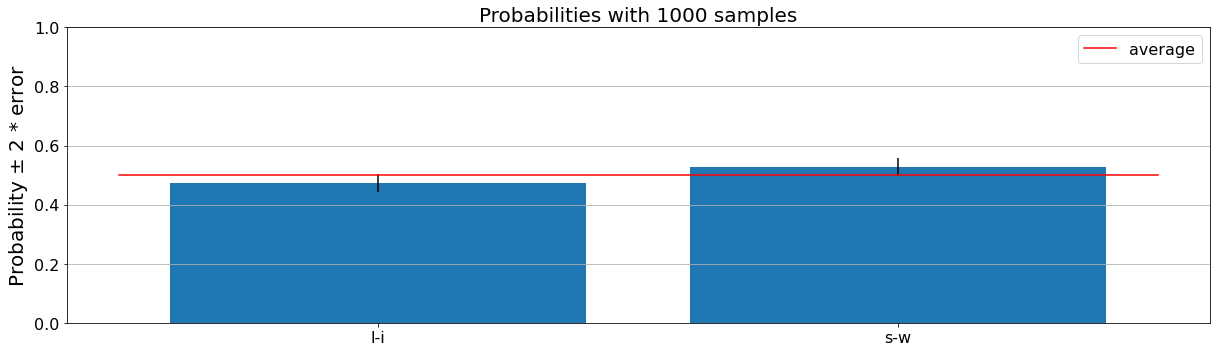

In [50]:
df2 = pd.concat([black_male_df_lipstick, black_male_df_swakife], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./bm_ls_sak_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "bm_ls_sak_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [ ]:
#White male lipstick - swiss army knife

lipstick
Size of the group: 4769
swiss-army-knives
Size of the group: 4769
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['lipstick', 'swiss-army-knives'])
The statistic is: [478. 522.]
Size of the sample: 1000
total time used: 453.2166154384613 seconds.
time used per comparison: 0.4532166154384613 seconds.
['l-i', 's-w']
<class 'numpy.float64'> <class 'list'>


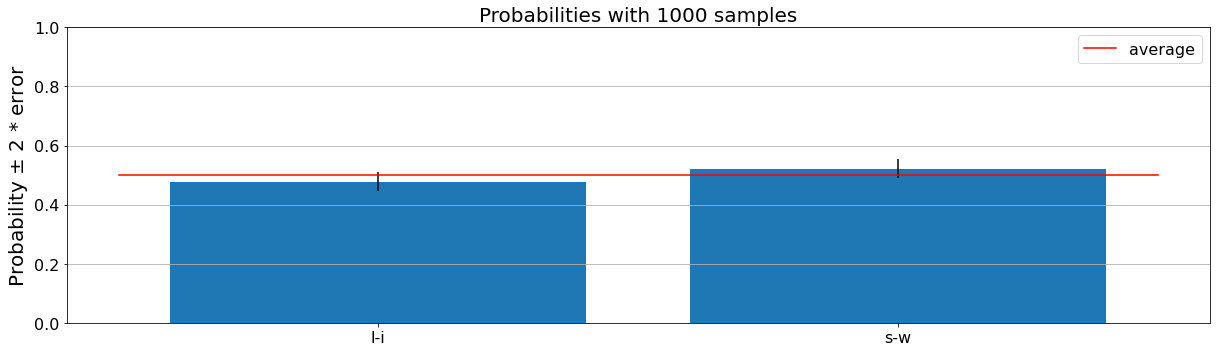

In [51]:
df2 = pd.concat([white_male_df_lipstick, white_male_df_swakife], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./wm_ls_sak_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "wm_ls_sak_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [52]:
#Black female lipstick - swiss army knife

lipstick
Size of the group: 3104
swiss-army-knives
Size of the group: 3104
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['lipstick', 'swiss-army-knives'])
The statistic is: [448. 552.]
Size of the sample: 1000
total time used: 510.7033197879791 seconds.
time used per comparison: 0.5107033197879791 seconds.
['l-i', 's-w']
<class 'numpy.float64'> <class 'list'>


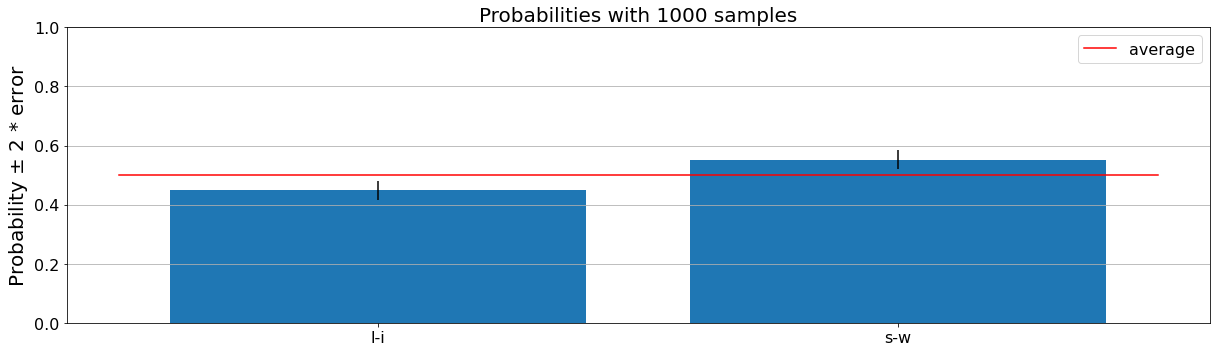

In [53]:
df2 = pd.concat([black_female_df_lipstick, black_female_df_swakife], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./bf_ls_sak_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "bf_ls_sak_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [54]:
#White female lipstick - swiss army knife

lipstick
Size of the group: 4500
swiss-army-knives
Size of the group: 4500
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['lipstick', 'swiss-army-knives'])
The statistic is: [469. 531.]
Size of the sample: 1000
total time used: 469.69697999954224 seconds.
time used per comparison: 0.46969697999954224 seconds.
['l-i', 's-w']
<class 'numpy.float64'> <class 'list'>


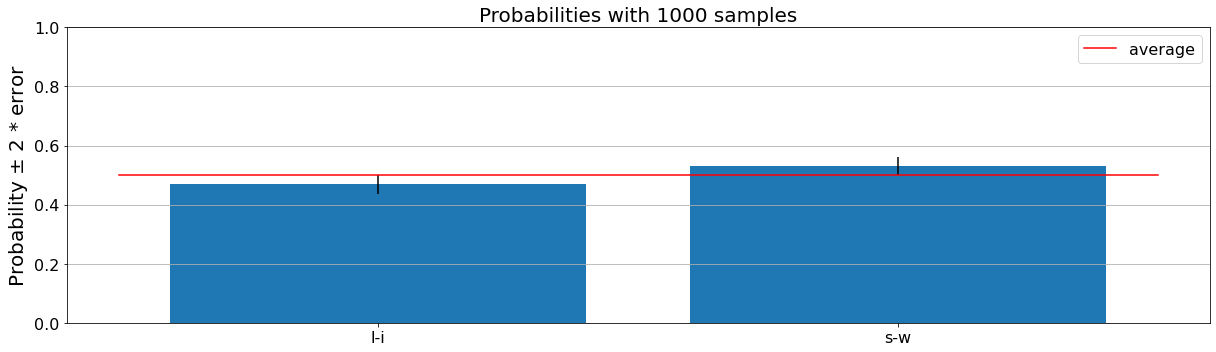

In [55]:
df2 = pd.concat([white_female_df_lipstick, white_female_df_swakife], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./wf_ls_sak_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "wf_ls_sak_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [ ]:
#Cheerleading Poms vs Swiss army knife

In [56]:
black_df = df[df["race"] == "Black"]
white_df = df[df["race"] == "White"]

black_male_df_cp = black_df[black_df["gender"] == "Male"]
black_female_df_cp = black_df[black_df["gender"] == "Female"]

black_male_df_swakife = black_df[black_df["gender"] == "Male"]
black_female_df_swakife = black_df[black_df["gender"] == "Female"]

white_male_df_cp = white_df[white_df["gender"] == "Male"]
white_female_df_cp = white_df[white_df["gender"] == "Female"]

white_male_df_swakife = white_df[white_df["gender"] == "Male"]
white_female_df_swakife = white_df[white_df["gender"] == "Female"]

In [57]:
def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-cheerleading-poms/{img_name}"
    
    return new_path

black_male_df_cp["path"] = black_male_df_handcuffs["path"].apply(change_path)
black_male_df_cp["attribute"] = "cp"


def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-cheerleading-poms/{img_name}"
    
    return new_path

white_male_df_cp["path"] = white_male_df_handcuffs["path"].apply(change_path)
white_male_df_cp["attribute"] = "cp"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-cheerleading-poms/{img_name}"
    
    return new_path

black_female_df_cp["path"] = black_female_df_handcuffs["path"].apply(change_path)
black_female_df_cp["attribute"] = "cp"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-cheerleading-poms/{img_name}"
    
    return new_path

white_female_df_cp["path"] = white_female_df_handcuffs["path"].apply(change_path)
white_female_df_cp["attribute"] = "cp"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-male-swiss-army-knives/{img_name}"
    
    return new_path

black_male_df_swakife["path"] = black_male_df_luxury_watches["path"].apply(change_path)
black_male_df_swakife["attribute"] = "swiss-army-knives"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-male-swiss-army-knives/{img_name}"
    
    return new_path

white_male_df_swakife["path"] = white_male_df_luxury_watches["path"].apply(change_path)
white_male_df_swakife["attribute"] = "swiss-army-knives"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/black-female-swiss-army-knives/{img_name}"
    
    return new_path

black_female_df_swakife["path"] = black_female_df_luxury_watches["path"].apply(change_path)
black_female_df_swakife["attribute"] = "swiss-army-knives"

def change_path(img_path):
    img_name = img_path.split("/")[-1]
    new_path = f"../data/fairface/manipulated/white-female-swiss-army-knives/{img_name}"
    
    return new_path

white_female_df_swakife["path"] = white_female_df_luxury_watches["path"].apply(change_path)
white_female_df_swakife["attribute"] = "swiss-army-knives"

/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [58]:
#Black Male cp - swak

cp
Size of the group: 2942
swiss-army-knives
Size of the group: 2942
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['cp', 'swiss-army-knives'])
The statistic is: [587. 413.]
Size of the sample: 1000
total time used: 431.7500286102295 seconds.
time used per comparison: 0.4317500286102295 seconds.
['c-p', 's-w']
<class 'numpy.float64'> <class 'list'>


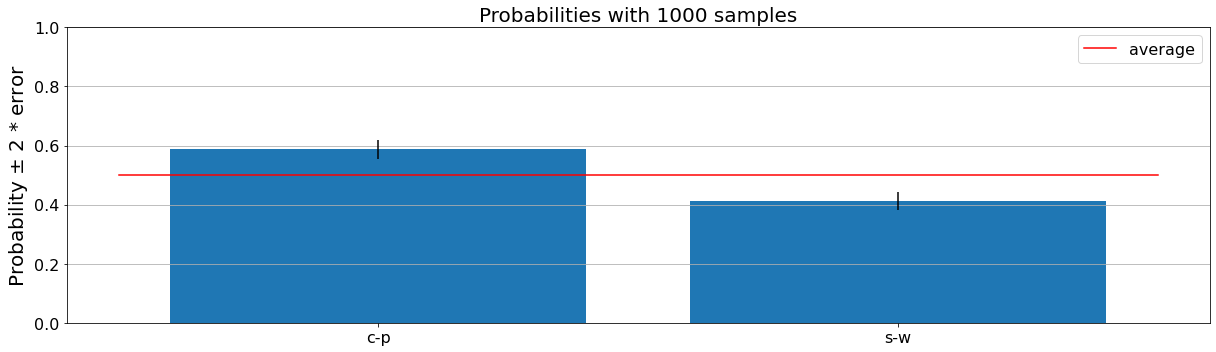

In [59]:
df2 = pd.concat([black_male_df_cp, black_male_df_swakife], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./bm_cp_sak_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "bm_cp_sak_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [60]:
#White male cp - swak

cp
Size of the group: 4769
swiss-army-knives
Size of the group: 4769
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['cp', 'swiss-army-knives'])
The statistic is: [621. 379.]
Size of the sample: 1000
total time used: 446.60383129119873 seconds.
time used per comparison: 0.44660383129119874 seconds.
['c-p', 's-w']
<class 'numpy.float64'> <class 'list'>


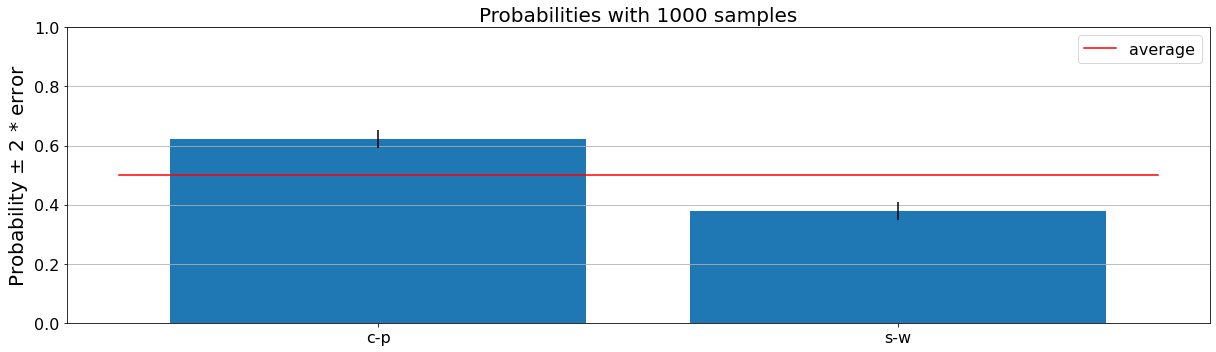

In [61]:
df2 = pd.concat([white_male_df_cp, white_male_df_swakife], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./wm_cp_sak_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "wm_cp_sak_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [62]:
#Black Female cp - swak

cp
Size of the group: 3104
swiss-army-knives
Size of the group: 3104
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['cp', 'swiss-army-knives'])
The statistic is: [582. 418.]
Size of the sample: 1000
total time used: 450.7573094367981 seconds.
time used per comparison: 0.4507573094367981 seconds.
['c-p', 's-w']
<class 'numpy.float64'> <class 'list'>


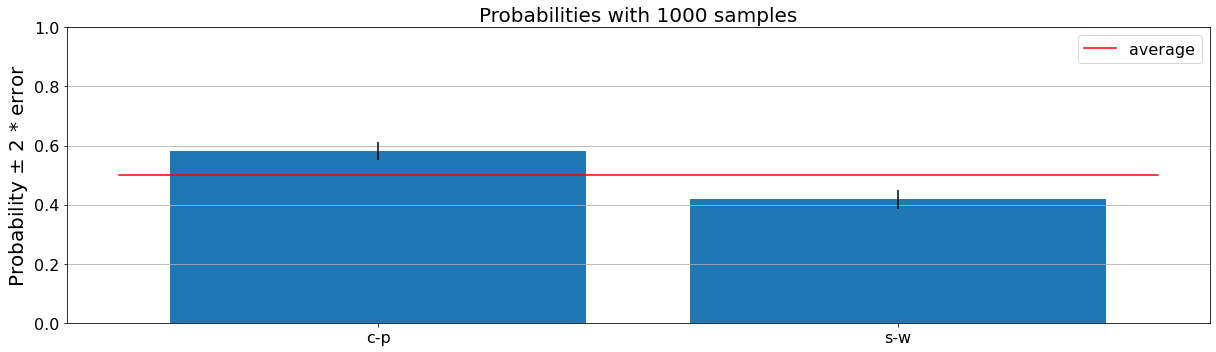

In [63]:
df2 = pd.concat([black_female_df_cp, black_female_df_swakife], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./bf_cp_sak_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "bf_cp_sak_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)

In [64]:
#White Female cp - swak

cp
Size of the group: 4500
swiss-army-knives
Size of the group: 4500
100 / 1000 iterations of sampling has been done.
200 / 1000 iterations of sampling has been done.
300 / 1000 iterations of sampling has been done.
400 / 1000 iterations of sampling has been done.
500 / 1000 iterations of sampling has been done.
600 / 1000 iterations of sampling has been done.
700 / 1000 iterations of sampling has been done.
800 / 1000 iterations of sampling has been done.
900 / 1000 iterations of sampling has been done.
1000 / 1000 iterations of sampling has been done.
The groups entered are: dict_keys(['cp', 'swiss-army-knives'])
The statistic is: [586. 414.]
Size of the sample: 1000
total time used: 450.66588497161865 seconds.
time used per comparison: 0.45066588497161864 seconds.
['c-p', 's-w']
<class 'numpy.float64'> <class 'list'>


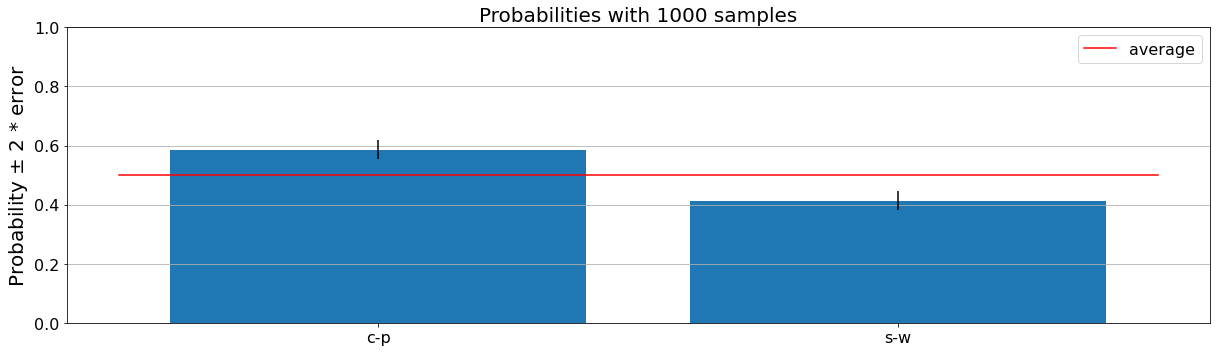

In [65]:
df2 = pd.concat([white_female_df_cp, white_female_df_swakife], sort=True)
df2 = df2.sort_index()

# choose your option here
grouped_images_dict = get_grouped_images(
    df2, by_columns=["attribute"]
)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

RESULT_FILE_PATH = data_dir / "./wf_cp_sak_results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
    
# change the setting here
NUM_ITERATION = 1000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept


SETTING_NAME = "wf_cp_sak_no_scaling_intersect_together"  

max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(17, 5),
    x_label_angle=0,
)